In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations

# Importation des données

In [2]:
datas = {
    f"data{i}": np.loadtxt(f"./data/data_tp{i}_app.txt") for i in range(1, 4)
}

for data in datas:
    datas[data] = pd.DataFrame(datas[data], columns=["y", "x1", "x2"])


valid_data = {
    f"data{i}": np.loadtxt(f"./data/data_tp{i}_dec.txt") for i in range(1, 4)
}


for data in valid_data:
    valid_data[data] = pd.DataFrame(valid_data[data], columns=["y", "x1", "x2"])

In [3]:
# image gif
description = {
    f"desc_tp{i}": plt.imread(f"./data/data_tp{i}_app.gif") for i in range(1, 4)
}


# Fonctions ou classes utiles

In [4]:
from abc import ABC, abstractmethod

class Modele(ABC):
    def __init__(self):
        pass
    
    @abstractmethod
    def fit(self, X, y):
        pass

       
    def plot_decision(self, X, sample = 300):
        """Uses Matplotlib to plot and fill a region with 2 colors
        corresponding to 2 classes, separated by a decision boundary

        Parameters
        ----------
        sample : int, optional
            Number of samples on each feature (default is 300)
        """

        x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
        x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
        x1_list = np.linspace(x1_min, x1_max, sample)
        x2_list = np.linspace(x2_min, x2_max, sample)
        y_grid_pred = [[self.predictor(np.array([x1,x2])) for x1 in x1_list] for x2 in x2_list] 
        plt.contourf(x1_list, x2_list, y_grid_pred, levels=1,alpha=0.35)


    def plot_decision_multi(self, X, sample = 300):
        """Uses Matplotlib to plot and fill a region with 2 colors
        corresponding to 2 classes.

        Parameters
        ----------
        sample : int, optional
            Number of samples on each feature (default is 300)
        """

        x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
        x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
        x1_list = np.linspace(x1_min, x1_max, sample)
        x2_list = np.linspace(x2_min, x2_max, sample)
        y_grid_pred = [[self.predictor (np.array([[x1,x2]]))[0] for x1 in x1_list] for x2 in x2_list] 
        l = np.shape(np.unique(y_grid_pred))[0] - 1
        plt.contourf(x1_list, x2_list, y_grid_pred, levels=l, colors=plt.rcParams['axes.prop_cycle'].by_key()['color'], alpha=0.35)


In [40]:
def top_k_accuracy(X, y_true, modele : Modele, k=2):
    if k == 1:
        labels = modele.predictor(X)
        score = [ 1 if y_true[i] == labels[i] else 0 for i in range(len(y_true))]
        
    else:
        labels = modele.rank_predictor(X)
        score = [ 1 if y_true[i] in labels[i,:k] else 0 for i in range(len(y_true))]

    return np.mean(score)


def validate(valid_data, modele : Modele, name=None, top_k_metrics=False):
    
    x_valid, y_valid = valid_data[["x1", "x2"]].to_numpy(), valid_data.y.to_numpy()
    classes = np.unique(y_valid)
    
    y_pred = modele.predictor(x_valid)
    valid_data["y_pred"] = y_pred

    top1, top2 = None, None
    if top_k_metrics:
        top1 = top_k_accuracy(x_valid, y_valid, modele, 1)
        top2 = top_k_accuracy(x_valid, y_valid, modele, 2)
        print(f"top1 : {top1}\n top2 : {top2}")
        

    matrice_confusion = np.zeros((len(classes), len(classes)))
    matrice_confusion = pd.DataFrame(matrice_confusion)
    matrice_confusion.columns =  np.arange(len(classes))
    matrice_confusion.index = matrice_confusion.columns
    
    for classe1 in  range(len(classes)):
        for classe2 in  range(len(classes)):
            matrice_confusion.loc[classe1, classe2] = valid_data[(valid_data.y_pred == classe1+1) & (valid_data.y == classe2+1)].shape[0]


    if len(classes) == 2:
        plt.figure()

        plt.axis('off')
        plt.show()

        plt.figure()
        
        plt.text(0, 0, f"vrai positive : {matrice_confusion.loc[0, 0]}", ha='center', fontsize=12, va='center', color='red')
        plt.text(1, 0, f"faux positive : {matrice_confusion.loc[0, 1]}", ha='center', fontsize=12,  va='center', color='red')
        plt.text(0, 1, f"faux negative : {matrice_confusion.loc[1, 0]}", ha='center', fontsize=12, va='center', color='red')
        plt.text(1, 1, f"vrai negative : {matrice_confusion.loc[1, 1]}", ha='center', fontsize=12, va='center', color='red')

        plt.axis("off")
        plt.imshow(matrice_confusion, cmap='YlGnBu', interpolation='nearest')
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrice_confusion, annot=True, cmap='coolwarm', fmt='.1f', linewidths=.5)
        plt.title(f"Matrice de confusion {name}")
        plt.xlabel('Columns')
        plt.ylabel('Rows')
        plt.show()
    
    return [top1, top2]

def show(df, save=True, title=None, delta =None):
    
    classes = df.y.unique()
    marker =  ["+","x",".","o",",","*","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    repartitons = {classe : df[df.y == classe] for classe in classes}
    
    plt.figure(figsize=(10, 8))
    
    for i, classe in enumerate(classes):
        card = repartitons[classe].size
        plt.scatter(repartitons[classe].x1, repartitons[classe].x2, marker=marker[i], alpha=.7, label=f"{str(classe)}, {card}")


    if title is not None:
        plt.title(title)

    if delta is not None:
        for deltai in delta:
            plt.axvline(deltai )
            plt.text(deltai, 2, f"{np.round(deltai)}")

    plt.axis("equal")
    plt.legend()

def plot_decision(x1_min, x1_max, x2_min, x2_max, prediction, sample = 300):
    """Uses Matplotlib to plot and fill a region with 2 colors
    corresponding to 2 classes, separated by a decision boundary

    Parameters
    ----------
    x1_min : float
        Minimum value for the first feature
    x1_max : float
        Maximum value for the first feature
    x2_min : float
        Minimum value for the second feature
    x2_max : float
        Maximum value for the second feature
    prediction :  (x : 2D vector) -> label : int
        Prediction function for decision
    sample : int, optional
        Number of samples on each feature (default is 300)
    """
    x1_list = np.linspace(x1_min, x1_max, sample)
    x2_list = np.linspace(x2_min, x2_max, sample)
    y_grid_pred = [[prediction(np.array([x1,x2])) for x1 in x1_list] for x2 in x2_list] 
    plt.contourf(x1_list, x2_list, y_grid_pred, levels=1,alpha=0.35)


def plot_decision_multi(x1_min, x1_max, x2_min, x2_max, prediction, sample = 300):
    """Uses Matplotlib to plot and fill a region with 2 colors
    corresponding to 2 classes.

    Parameters
    ----------
    x1_min : float
        Minimum value for the first feature
    x1_max : float
        Maximum value for the first feature
    x2_min : float
        Minimum value for the second feature
    x2_max : float
        Maximum value for the second feature
    prediction :  (x : 2D vector) -> label : int
        Prediction function for a vector x
    sample : int, optional
        Number of samples on each feature (default is 300)
    """
    x1_list = np.linspace(x1_min, x1_max, sample)
    x2_list = np.linspace(x2_min, x2_max, sample)
    y_grid_pred = [[prediction(np.array([[x1,x2]]))[0] for x1 in x1_list] for x2 in x2_list] 
    l = np.shape(np.unique(y_grid_pred))[0] - 1
    plt.contourf(x1_list, x2_list, y_grid_pred, levels=l, colors=plt.rcParams['axes.prop_cycle'].by_key()['color'], alpha=0.35)

def execute_modele(modele : Modele, data=None, sample=300, top_k_metrics=False):
    if data is not None:
        X_train = data[["x1", "x2"]].to_numpy()
        y_train = data.y.to_numpy().astype(int)
        modele.fit(X_train, y_train)
        show(data)
        modele.plot_decision_multi(X_train, sample=sample)
        top_result = validate(data, modele, top_k_metrics=top_k_metrics)
        plt.show()
    else:   
        top_results = []
        for data in datas:
            X_train = datas[data][["x1", "x2"]].to_numpy()
            y_train = datas[data].y.to_numpy()
            X_valid = valid_data[data][["x1", "x2"]].to_numpy()
            y_valid = valid_data[data].y.to_numpy()
            modele.fit(X_train, y_train)
            show(valid_data[data], title=f"Train Data {data[-1]}")
            modele.plot_decision_multi(X_valid, sample=sample)
            top_result = validate(valid_data[data], modele, name=f"Validation Data {data[-1]}", top_k_metrics=top_k_metrics)
            top_results.append(top_result)
            plt.show()
    return top_results

def cross_validation(modele : Modele, X, y, cv=5):
    n = len(y)
    indices = np.arange(n)
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    top1_scores = []
    top2_scores = []
    for i in range(cv):
        test_indices = indices[i]
        train_indices = np.concatenate([indices[j] for j in range(cv) if j != i])
        modele.fit(X[train_indices], y[train_indices])
        top1_score = top_k_accuracy(X[test_indices], y[test_indices], modele, 1)
        top2_score = top_k_accuracy(X[test_indices], y[test_indices], modele, 2)
        top1_scores.append(top1_score)
        top2_scores.append(top2_score)
    return np.mean(top1_scores), np.mean(top2_scores)


# TP1 : Approche Bayessienne de la decision

class 1 mean: [-6.10093065  5.99640958] count: 100
class 2 mean: [5.79953605 6.17117138] count: 100
class 3 mean: [ 5.7769986  -5.92582723] count: 100
class 4 mean: [-5.92499809 -6.01392348] count: 100
class 5 mean: [-0.01358148  0.25138977] count: 100


<Figure size 640x480 with 0 Axes>

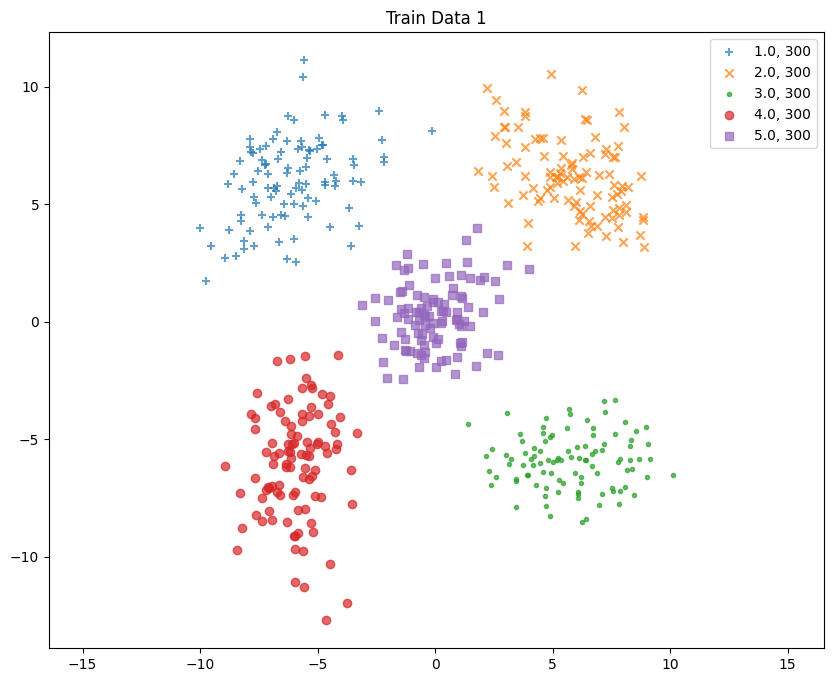

In [6]:
plt.figure()

X1 = datas["data1"][["x1", "x2"]].to_numpy()
y1 = datas["data1"].y.to_numpy().astype(int)

classes = np.unique(y1)

show(datas["data1"], title="Train Data 1")
for classe in classes:
   print(f"class {classe} mean: {X1[y1 == classe].mean(axis=0)} count: {X1[y1 == classe].shape[0]}")

## Estimation Gaussien

### Distance Euclidienne

In [38]:
class EuclideanClassifier(Modele):
    def __init__(self):
        pass
    
    def fit(self, X, y, k=5):
        classes = np.unique(y)
        means = np.array([X[y == classe].mean(axis=0) for classe in classes])
        
        self.predictor = self._get_predictor(means)
        self.rank_predictor = self._get_rank_predictor(means, k)

    def _get_predictor(self, means):
        def predict(x):
            if len(x.shape) == 1:
                return np.argmin([np.linalg.norm(mean - x) for mean in means]) + 1
            return np.argmin([np.linalg.norm(mean - x, axis=1) for mean in means], axis=0)  + 1
        return predict
    
    def _get_rank_predictor(self, means, k):
        def predict(x):
            if len(x.shape) == 1:
                return (np.argsort([np.linalg.norm(mean - x) for mean in means])[:k]) + 1
            return (np.argsort([np.linalg.norm(mean - x, axis=1) for mean in means], axis=0)[:k]).T + 1
        return predict


euclide_classifer = EuclideanClassifier()

top1 : 0.992
 top2 : 1.0


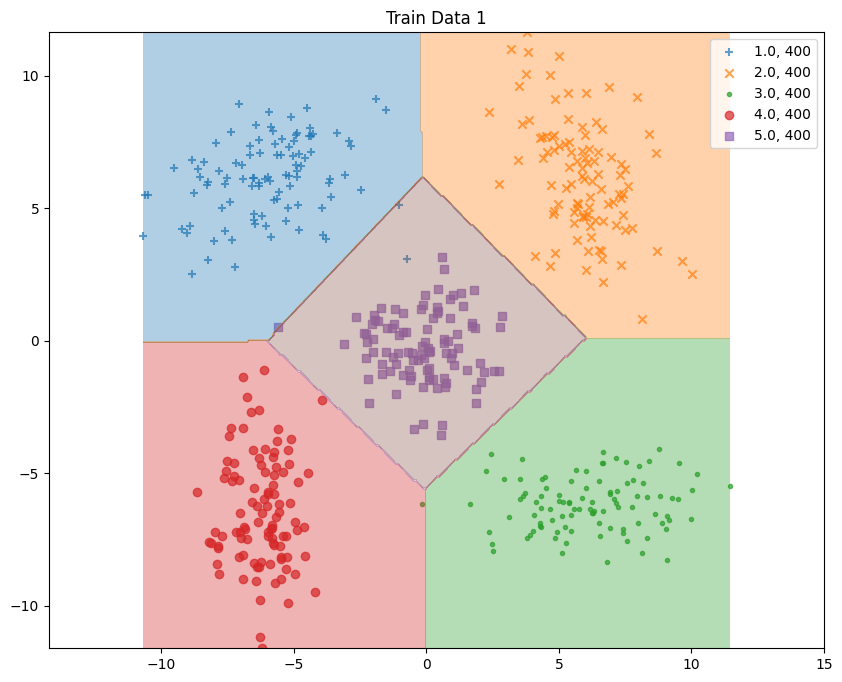

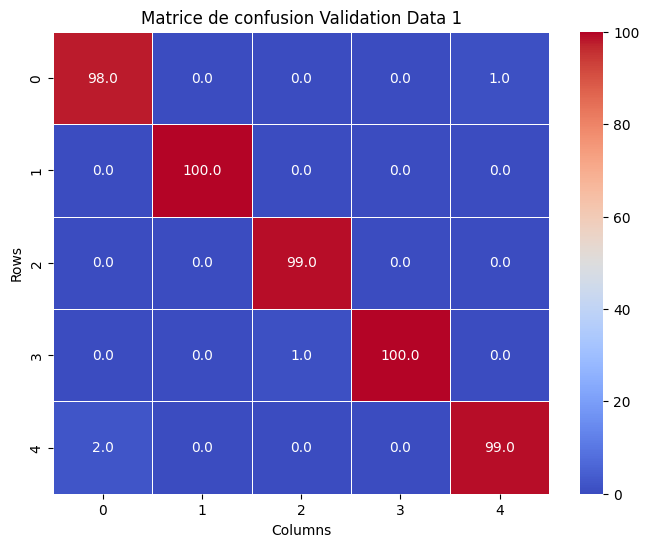

top1 : 0.946
 top2 : 0.996


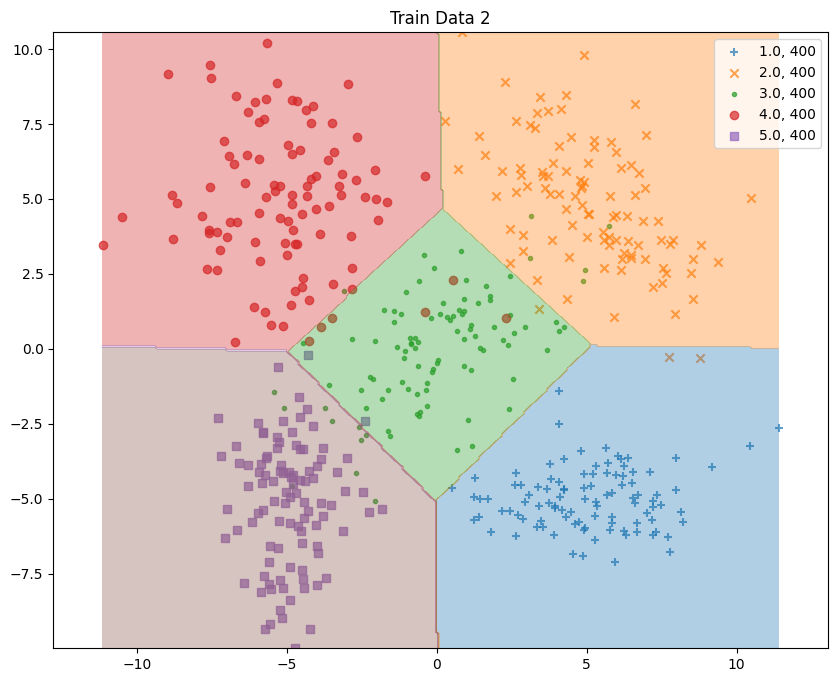

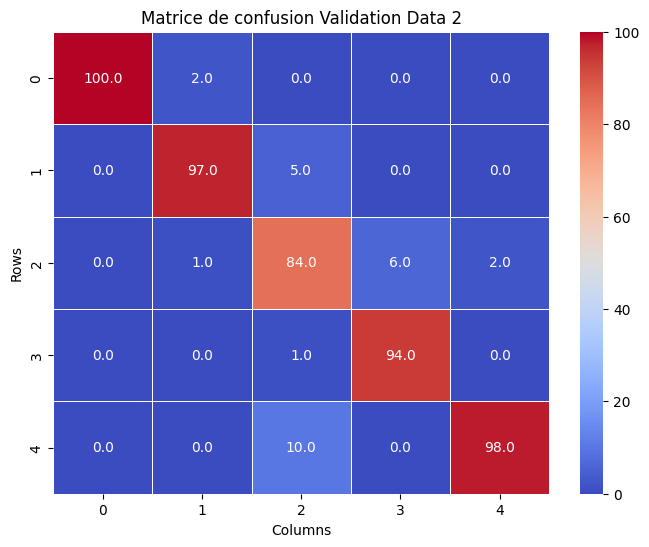

top1 : 0.728
 top2 : 0.892


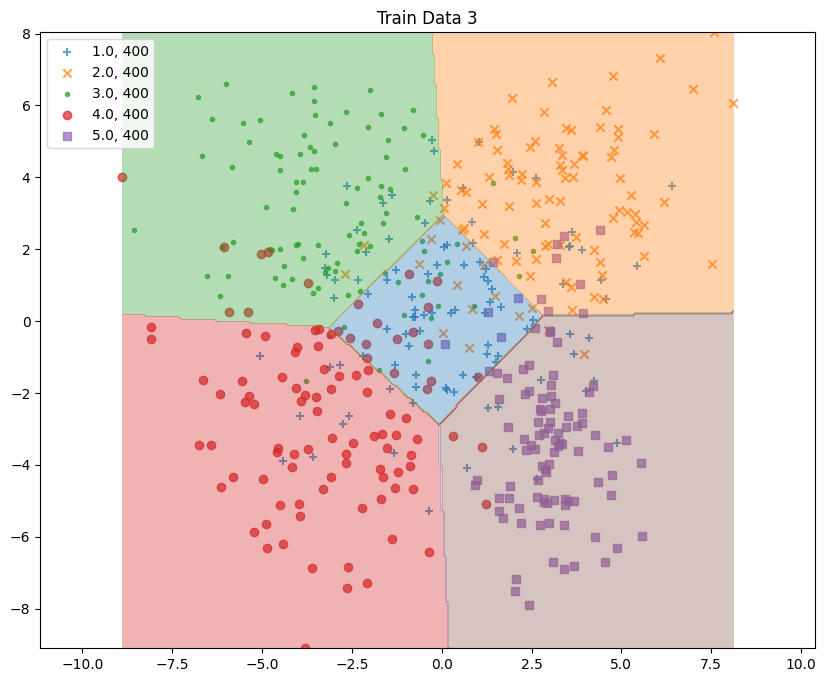

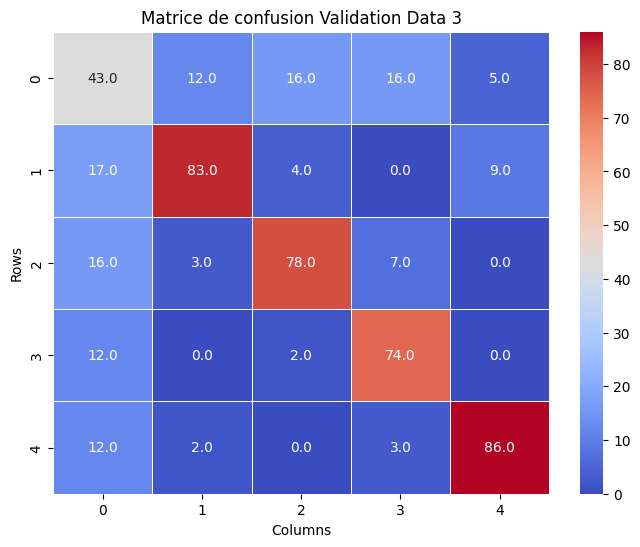

In [42]:
euclidian_top = execute_modele(euclide_classifer, top_k_metrics=True)

#### Conclusion

La classification par distance euclidienne est tres efficace sur les jeux de données 1 et 2.
Sur le jeu de données 3 la classification est moins bonnes car il existe de trés grandes zone d'indecion.

## Distance de mahalanobis

In [32]:

class MahalanobisClassifier(Modele):
    def __init__(self):
        self.predictor = None
    
    def fit(self, X, y):
        classes = np.unique(y)
        means = np.array([X[y == classe].mean(axis=0) for classe in classes])
        covs = np.array([np.cov(X[y == classe].T, rowvar=True) for classe in classes])
        inv_covs = np.array([np.linalg.inv(cov) for cov in covs])
        probas = np.array([X[y == classe].shape[0]/X.shape[0] for classe in classes])
        

        dets_sigma = [np.linalg.det(cov) for cov in covs]

        b = [np.log(det_sigma) - 2 * np.log(proba) for  det_sigma, proba in zip(dets_sigma, probas)]
        

        self.predictor = self._get_predictor(means, covs, b)
        self.rank_predictor = self._get_rank_predictor(means, covs, b)

    def _get_predictor(self, means, covs, b, distance=lambda x, y, sigma: np.sum((x@np.linalg.inv(sigma))*y, axis=1)):
        def predict(x):
            if len(x.shape) == 1:
                x = np.expand_dims(x, axis=0)
                return np.argmin([distance(x-mean, x-mean, cov) + b for mean, cov, b in zip(means, covs, b)]) + 1
            return np.argmin([distance(x-mean, x-mean, cov) + b for mean, cov, b in zip(means, covs, b)], axis=0) + 1
        return predict

    def _get_rank_predictor(self, means, covs, b, k=5,distance=lambda x, y, sigma: np.sum((x@np.linalg.inv(sigma))*y, axis=1)):
        def predict(x):
            if len(x.shape) == 1:
                x = np.expand_dims(x, axis=0)
                pred =(np.argsort([distance(x-mean, x-mean, cov) + b for mean, cov, b in zip(means, covs, b)], axis=0)) + 1
                return pred.reshape(-1)[:k]
            return (np.argsort([distance(x-mean, x-mean, cov) + b for mean, cov, b in zip(means, covs, b)], axis=0)[:k]).T + 1
        return predict 

top1 : 0.996
 top2 : 0.998


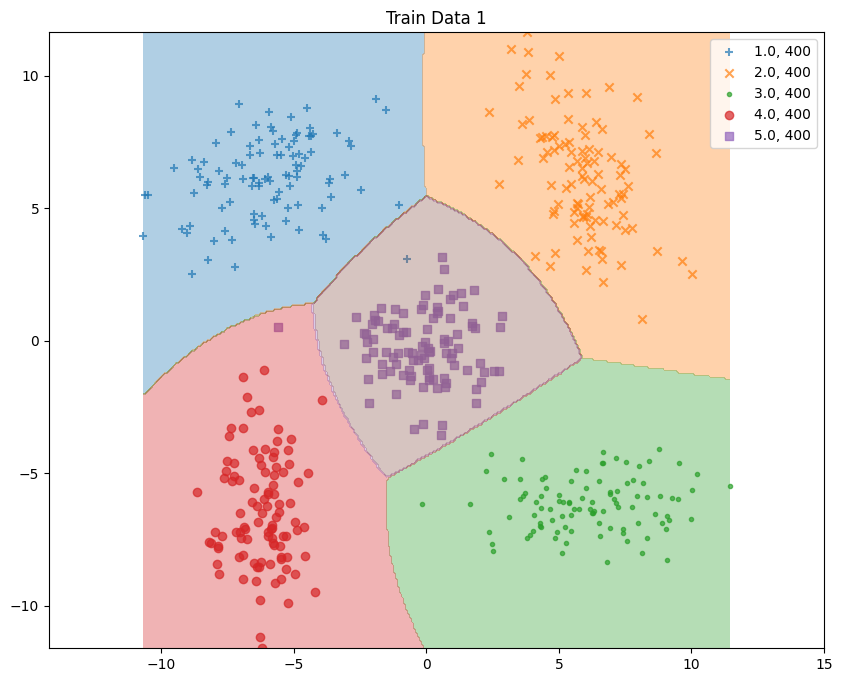

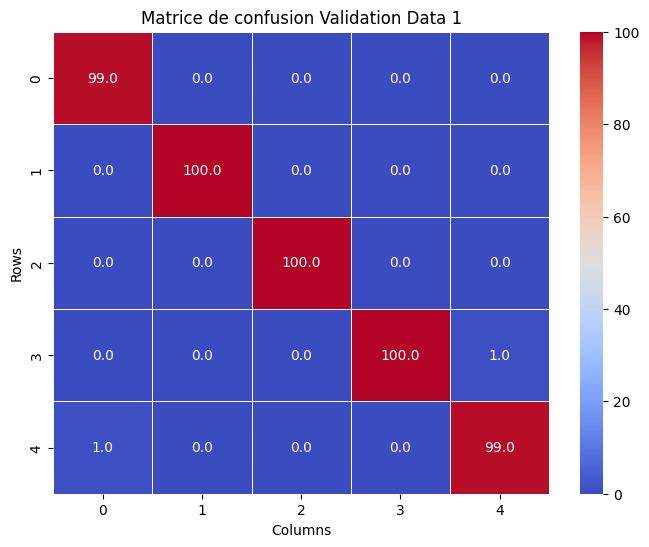

top1 : 0.946
 top2 : 0.994


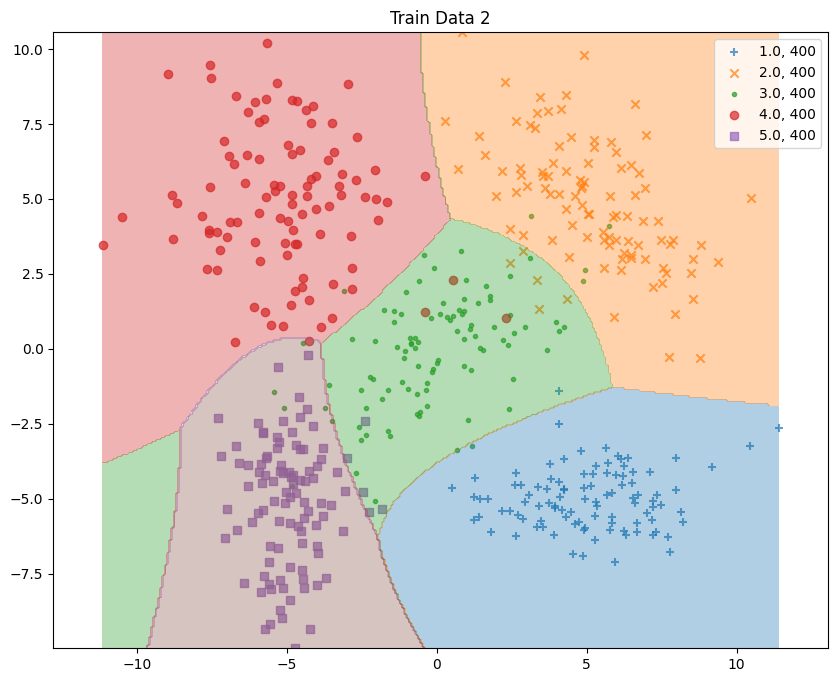

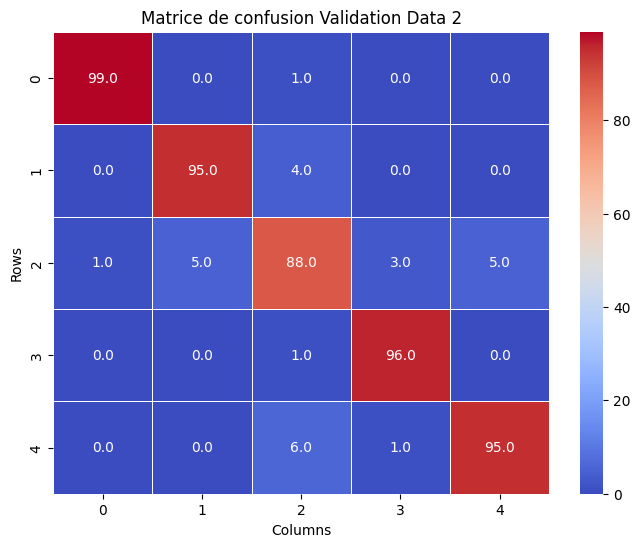

top1 : 0.698
 top2 : 0.872


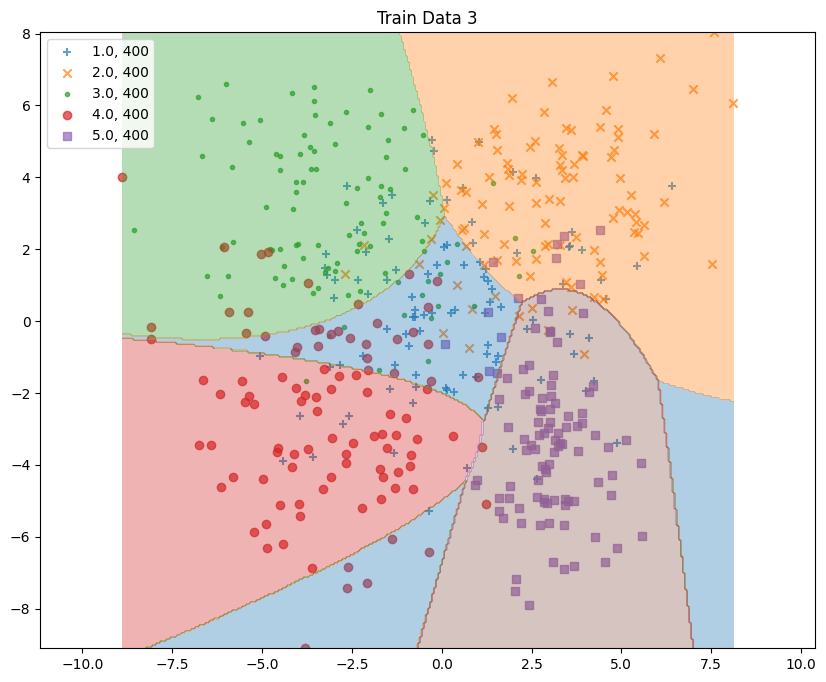

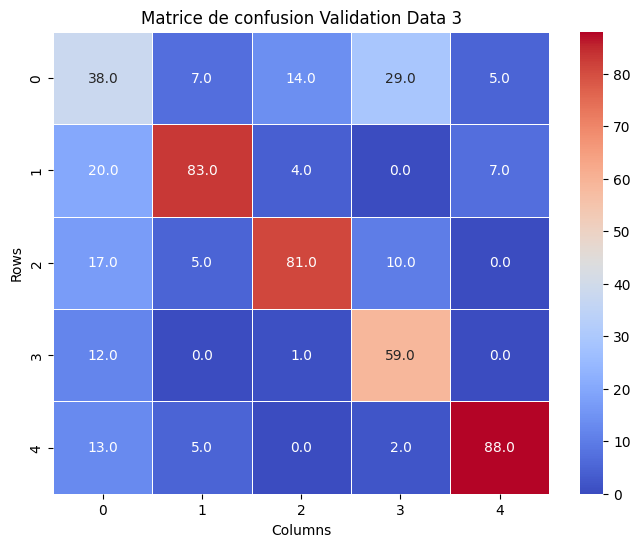

In [43]:
mahalanobis_classifier = MahalanobisClassifier()
mahalanobis_top = execute_modele(mahalanobis_classifier, top_k_metrics=True)

#### Conclusion

La classification par distance euclidienne est tres efficace sur les jeux de données 1 et 2.
Sur le jeu de données 3 la classification est moins bonnes car il existe de trés grandes zone d'indecion.

### Conclusion

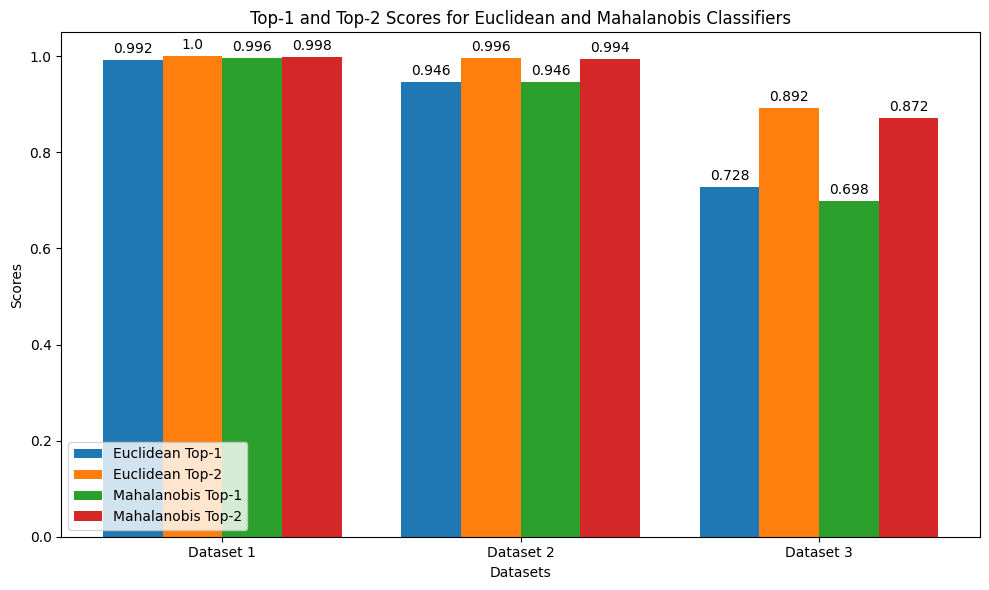

In [44]:
# python
# Assuming the two models' top-1 and top-2 scores are stored in lists `euclidian_top` and `mahalanobis_top`
# Each list contains tuples of (top-1 score, top-2 score) for each dataset

# Extracting top-1 and top-2 scores for both models
euclidian_top1 = [score[0] for score in euclidian_top]
euclidian_top2 = [score[1] for score in euclidian_top]
mahalanobis_top1 = [score[0] for score in mahalanobis_top]
mahalanobis_top2 = [score[1] for score in mahalanobis_top]

# Creating a bar plot
labels = ['Dataset 1', 'Dataset 2', 'Dataset 3']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, euclidian_top1, width, label='Euclidean Top-1')
rects2 = ax.bar(x, euclidian_top2, width, label='Euclidean Top-2')
rects3 = ax.bar(x + width, mahalanobis_top1, width, label='Mahalanobis Top-1')
rects4 = ax.bar(x + 2*width, mahalanobis_top2, width, label='Mahalanobis Top-2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Datasets')
ax.set_ylabel('Scores')
ax.set_title('Top-1 and Top-2 Scores for Euclidean and Mahalanobis Classifiers')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()


Les deux modéles classifie trés bien le jeux de données N° 1.

Le classifieur de mahalanobis est plus performant que le classifieur euclidien sur le jeu de données 2 de dernier presente des cluster avec un covariance des variable.

Les deux modéles ont tous du mal à classifier le jeu de données numero 3.
N'empeche le classifieur de mahalanobis est plus performant.

## Parzen

In [7]:
def gaussian_kernel(x):
    return (1/np.pi**len(x))*np.exp(-x.T@x/2)

def uniform_kernel(x):
    return 1/2*(np.linalg.norm(x) <= .5)

In [41]:
class Parzen(Modele):
    def __init__(self, kernel=gaussian_kernel, h=1):
        self.kernel = kernel
        self.h = h
        self.predictor = None
        self.rank_predictor = None

    def fit(self, X, y, ):
        self.classes = np.unique(y)
        self.estimators = []
        self.X = X
        self.y = y
        self.probas = np.array([self.X[self.y == classe].shape[0]/self.X.shape[0] for classe in classes])
        self.predictor = self._get_predictor(self.h)
        self.rank_predictor = self._get_rank_predictor(self.h)
    
    def _vector_predict(self, x, h):
        
        estimations = []
        for classe in classes:
            XI = self.X[self.y == classe]
            estimation = np.sum([gaussian_kernel((x - xi)/h) for xi in XI])/(len(self.X) * h**self.X.shape[1])
            estimations.append(estimation)
        estimations = np.array(estimations)
        
        probas_a_posteriori = np.array([estimation * proba for estimation, proba in zip(estimations, self.probas)])
        pred = np.argmax(probas_a_posteriori)+1
        return pred
    
    def _vector_rank_predict(self, x, h, k):
        
        estimations = []
        for classe in classes:
            XI = self.X[self.y == classe]
            estimation = np.sum([gaussian_kernel((x - xi)/h) for xi in XI])/(len(self.X) * h**self.X.shape[1])
            estimations.append(estimation)
        estimations = np.array(estimations)

        probas_a_posteriori = np.array([estimation * proba for estimation, proba in zip(estimations, self.probas)])
        pred = np.argsort(probas_a_posteriori)[-k:]+1
        return pred

    def _get_predictor(self, h):
        def predict(x):
            if len(x.shape) == 1:
                return self._vector_predict(x, h)
            return np.array([self._vector_predict(xi, h) for xi in x])
        return predict

    def _get_rank_predictor(self, h, k=5):
        def predict(x):
            if len(x.shape) == 1:
                return self._vector_rank_predict(x, h, k)[::-1]
            return np.array([self._vector_rank_predict(xi, h, k)[::-1] for xi in x])
        return predict

In [37]:
parzen = Parzen(kernel=gaussian_kernel)
X2, y2 = datas["data2"][["x1", "x2"]].to_numpy(), datas["data2"].y.to_numpy().astype(int)
parzen.fit(X2, y2)
parzen.predictor(valid_data["data2"][["x1", "x2"]].to_numpy()[0])

np.int64(1)

top1 : 0.996
 top2 : 0.998


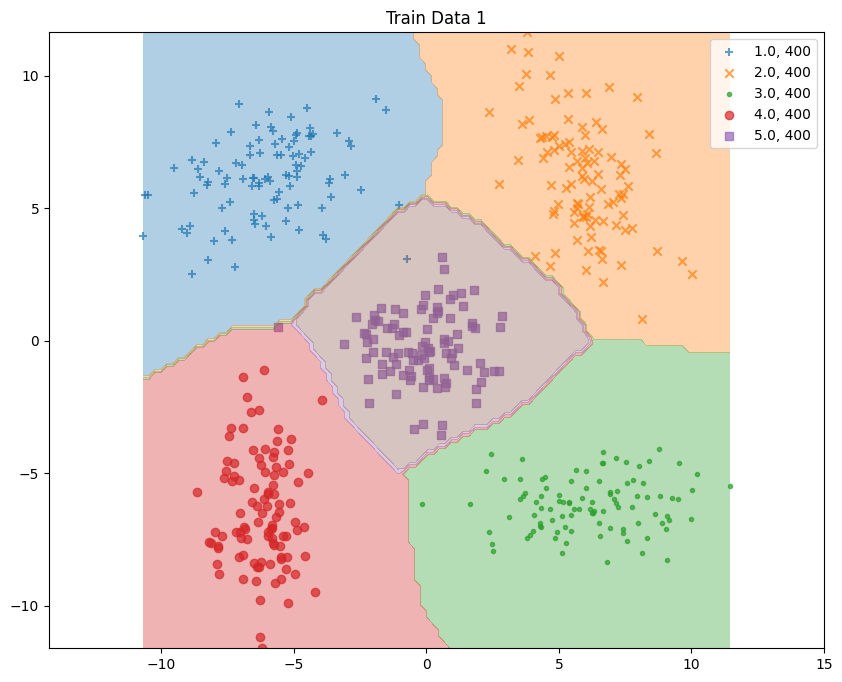

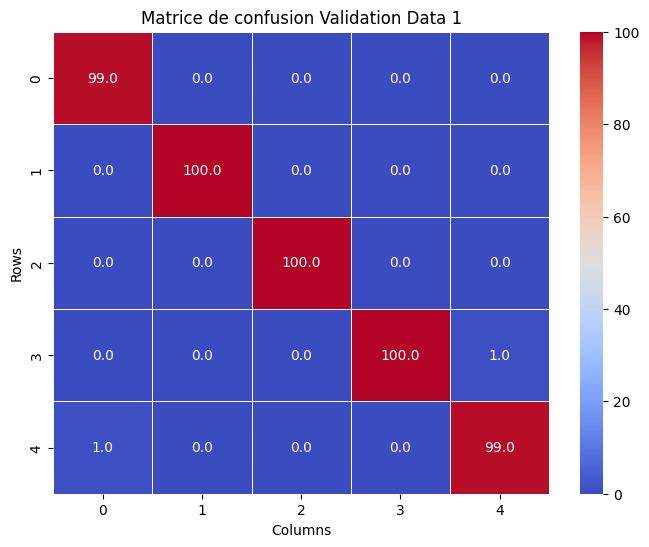

top1 : 0.948
 top2 : 0.994


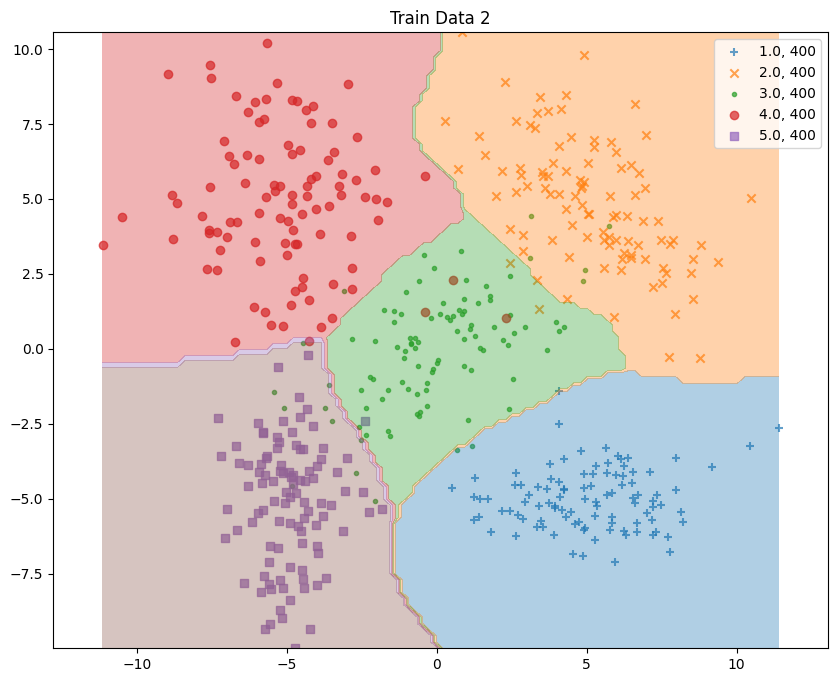

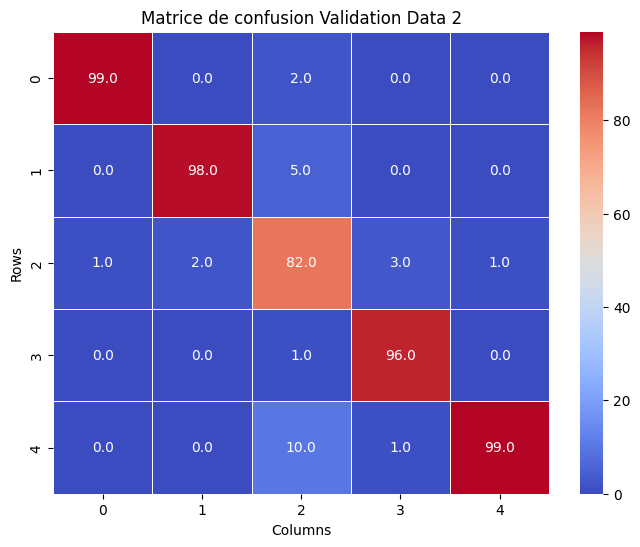

top1 : 0.712
 top2 : 0.864


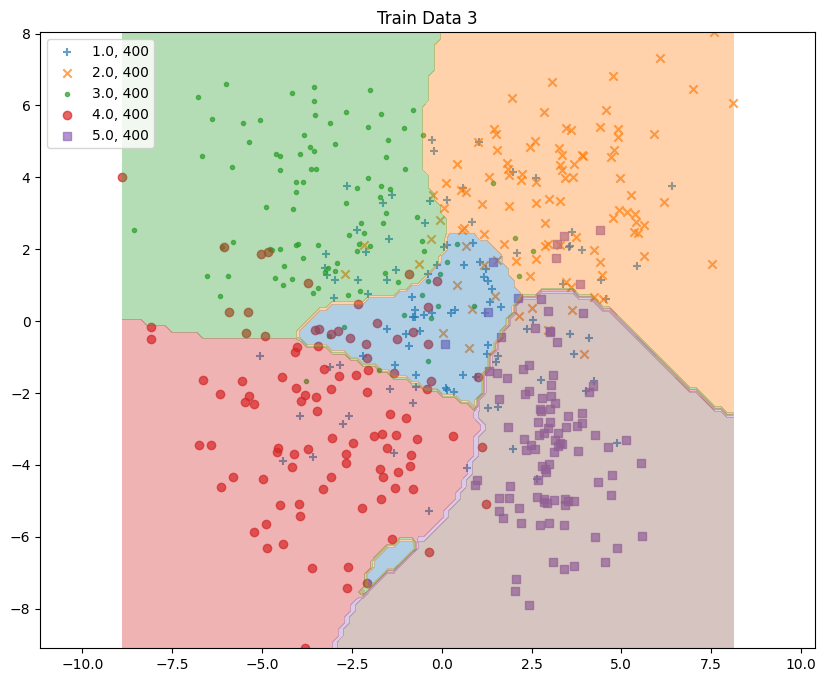

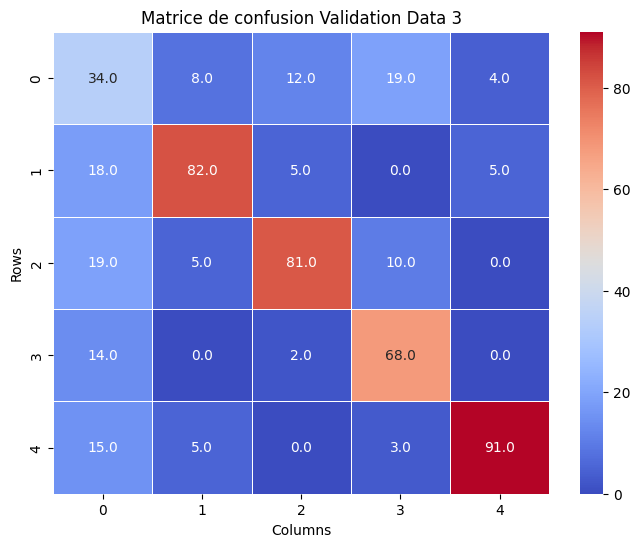

[[np.float64(0.996), np.float64(0.998)],
 [np.float64(0.948), np.float64(0.994)],
 [np.float64(0.712), np.float64(0.864)]]

In [38]:
parzen = Parzen(kernel=gaussian_kernel)
execute_modele(parzen, sample=100, top_k_metrics=True)

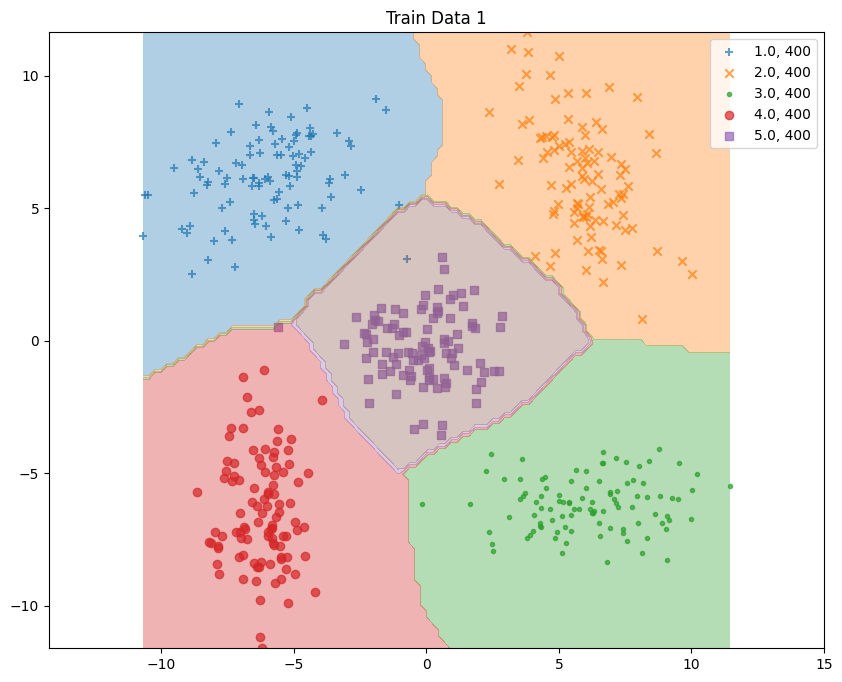

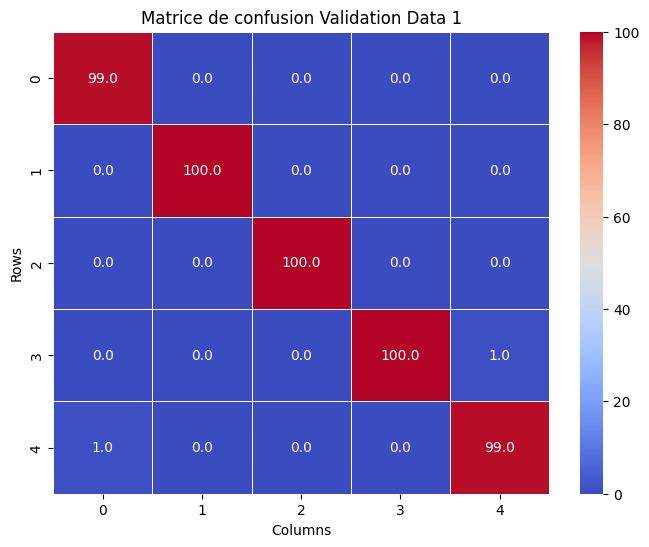

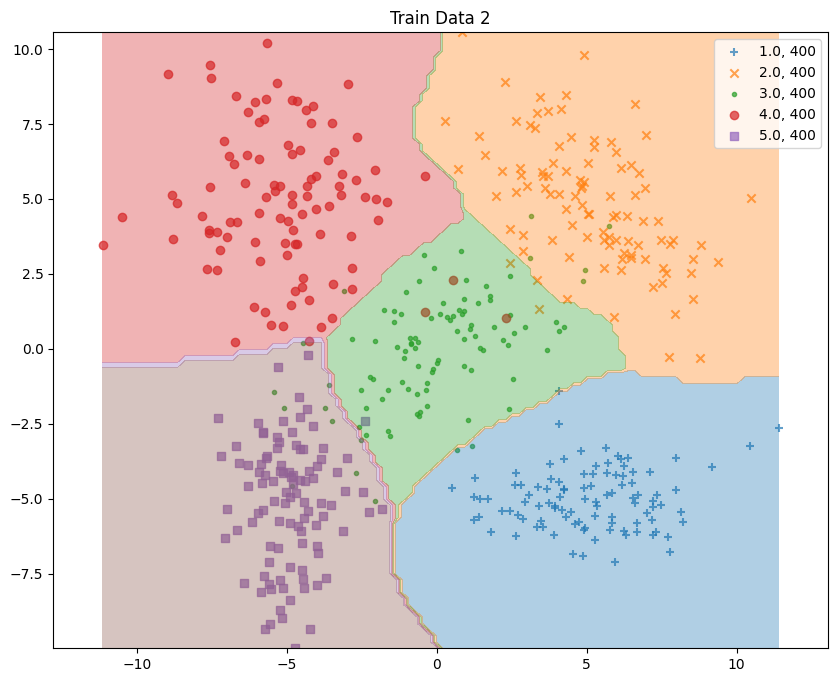

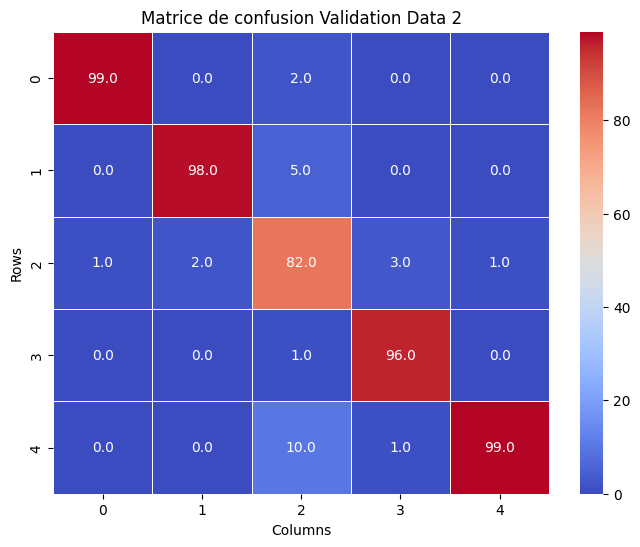

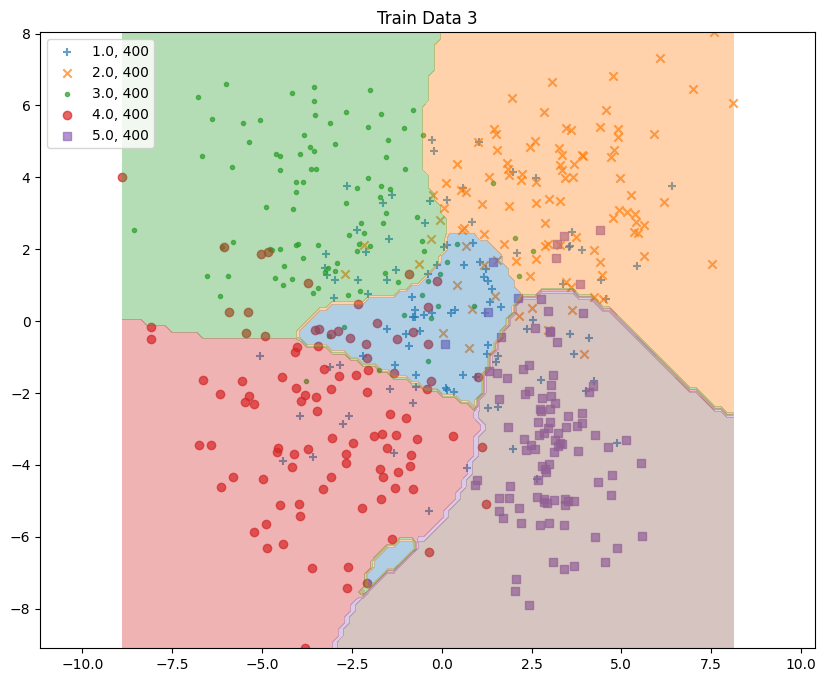

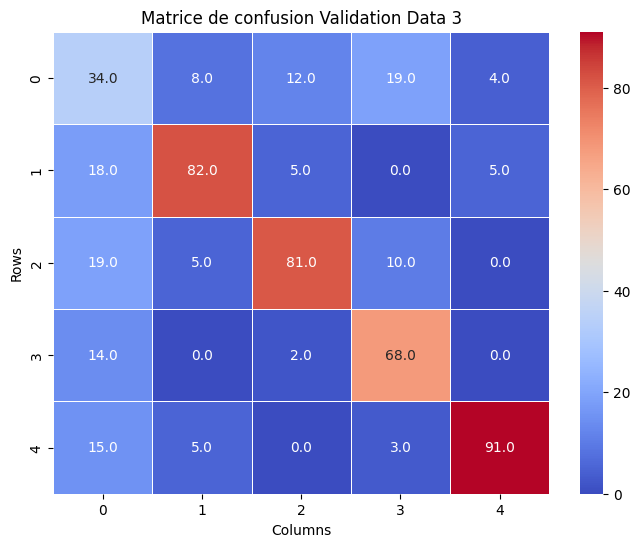

[[None, None], [None, None], [None, None]]

In [39]:
parzen = Parzen(kernel=uniform_kernel)
execute_modele(parzen, sample=100)

dataset 1
best h on gaussian with Top 1 score : 3, best h on gaussian with Top 2 score : 1
best h on uniform with Top 1 score : 1, best h on uniform with Top 2 score : 1


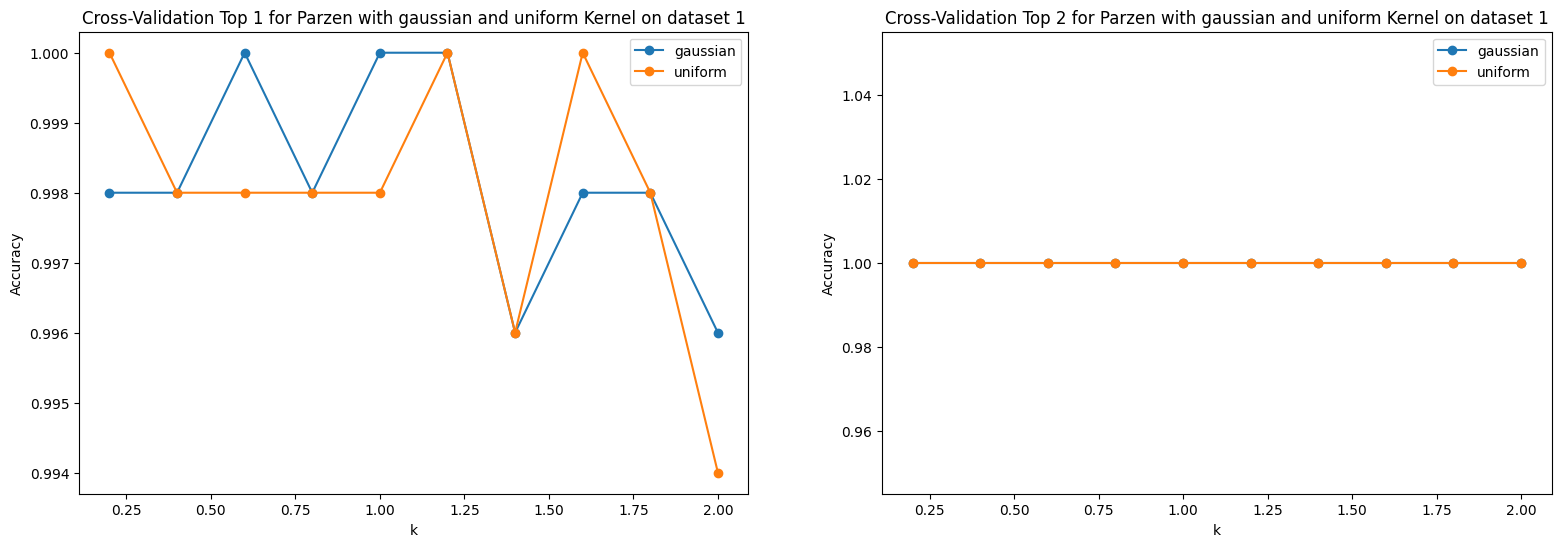

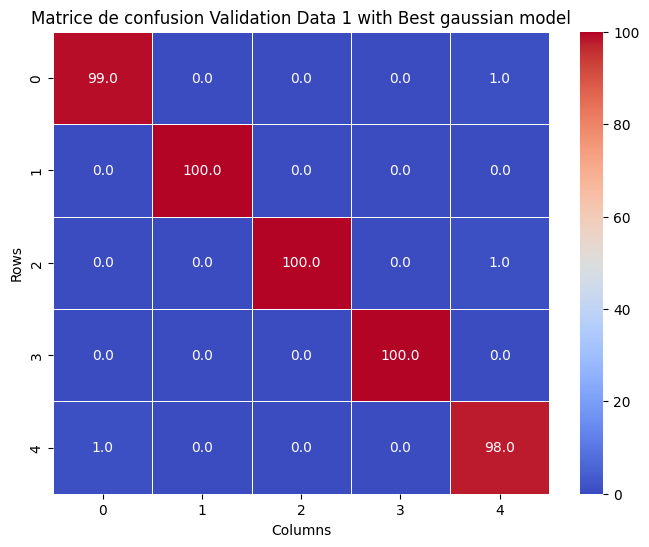

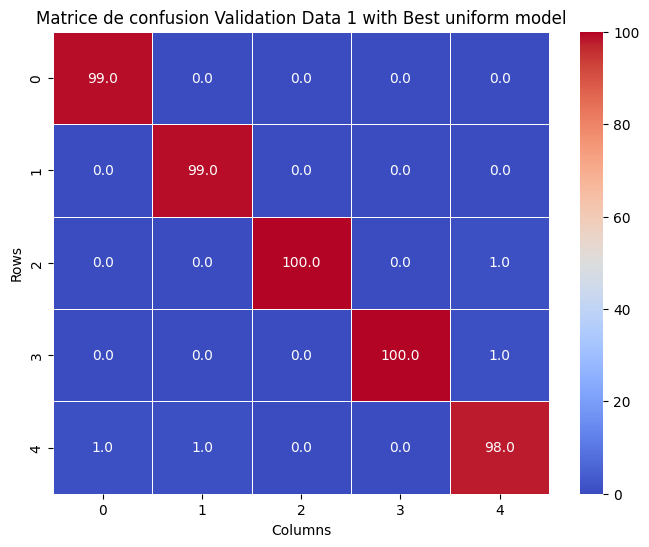

dataset 2
best h on gaussian with Top 1 score : 4, best h on gaussian with Top 2 score : 4
best h on uniform with Top 1 score : 5, best h on uniform with Top 2 score : 7


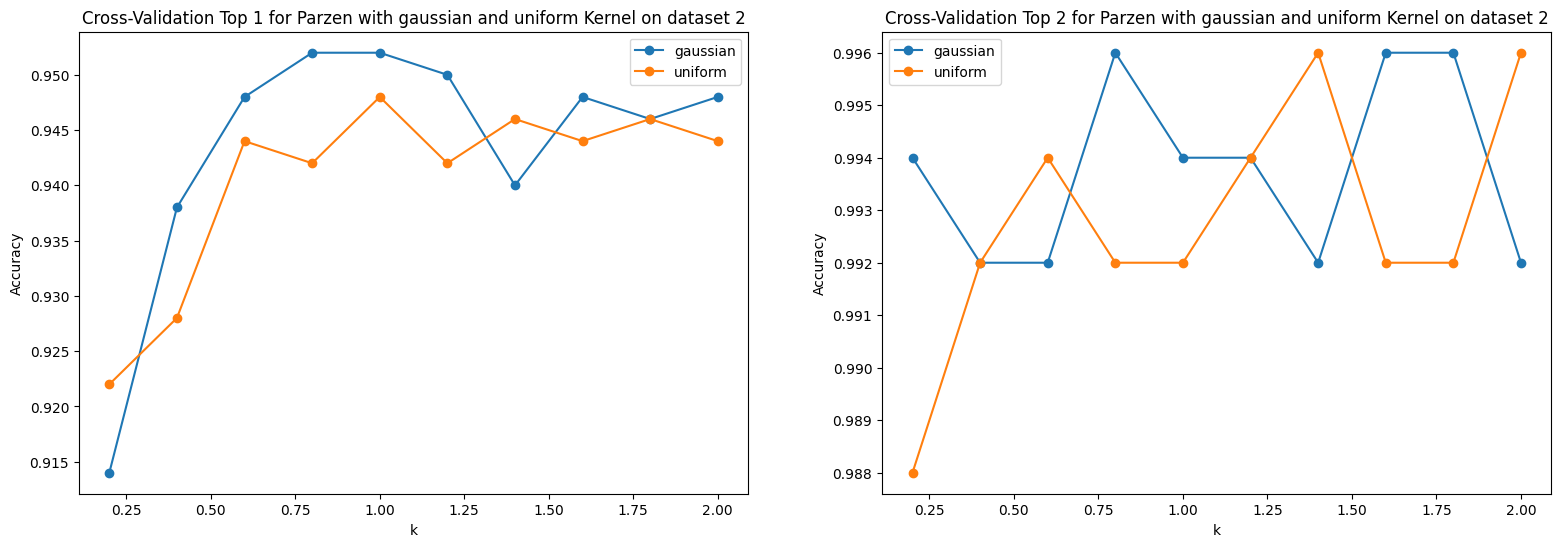

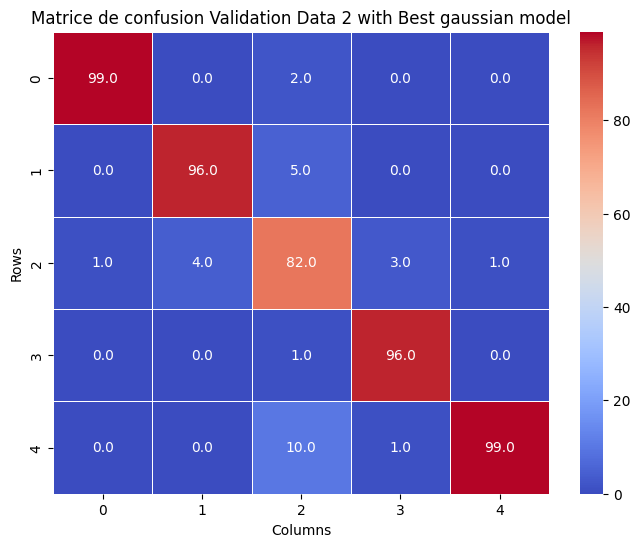

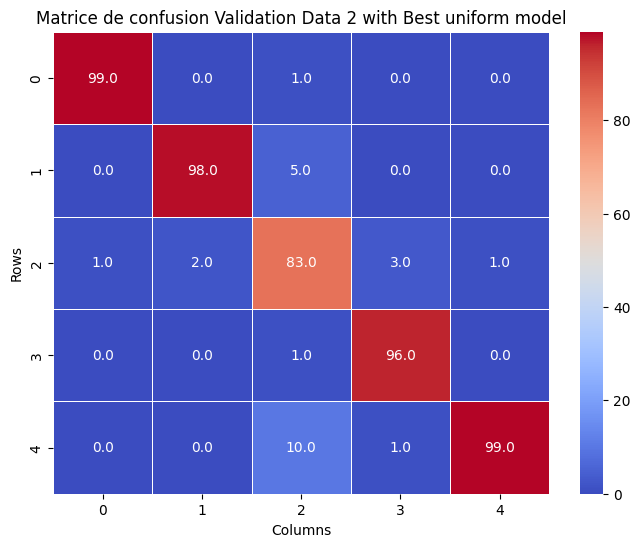

dataset 3
best h on gaussian with Top 1 score : 4, best h on gaussian with Top 2 score : 8
best h on uniform with Top 1 score : 3, best h on uniform with Top 2 score : 9


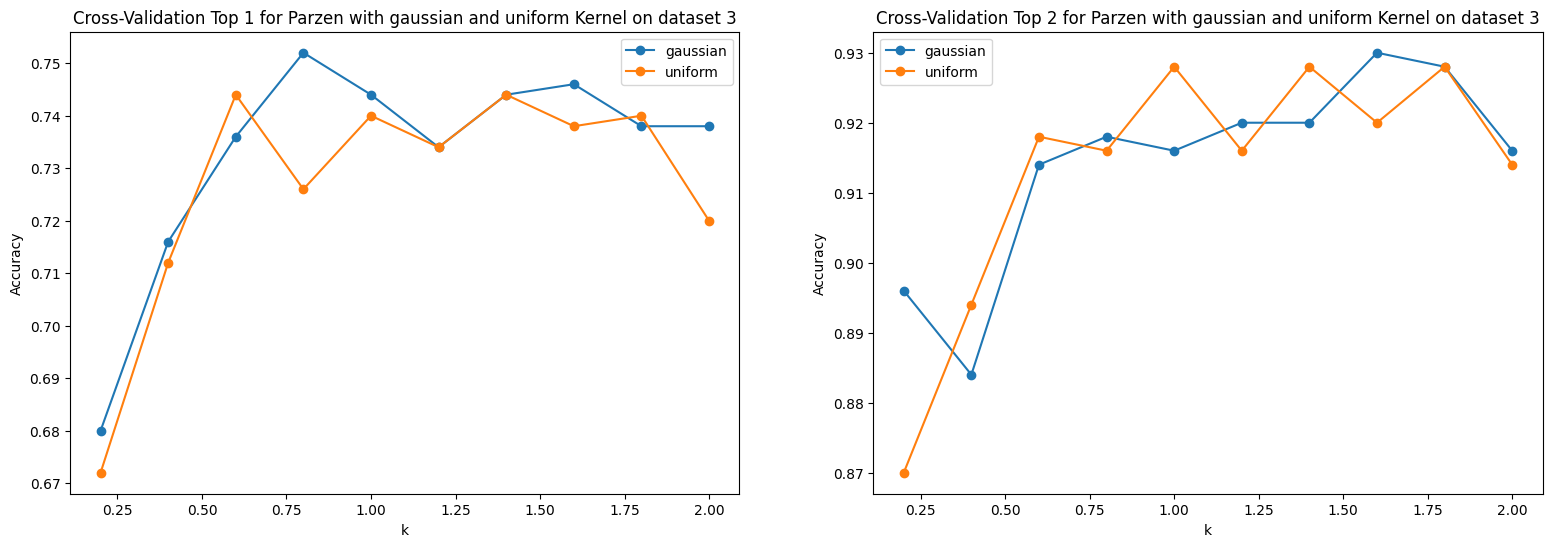

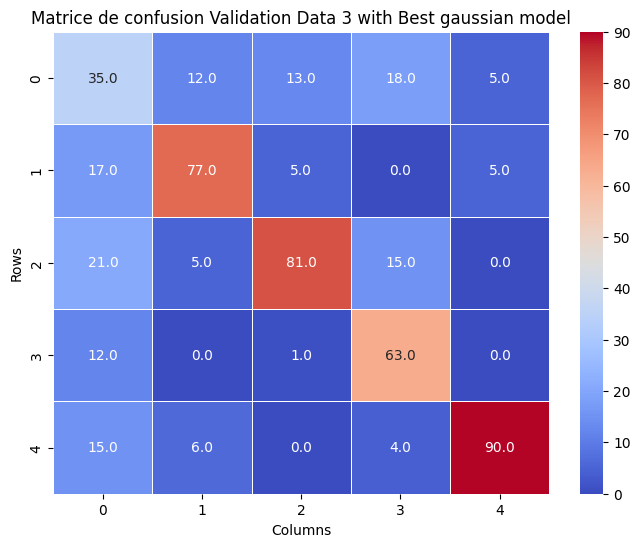

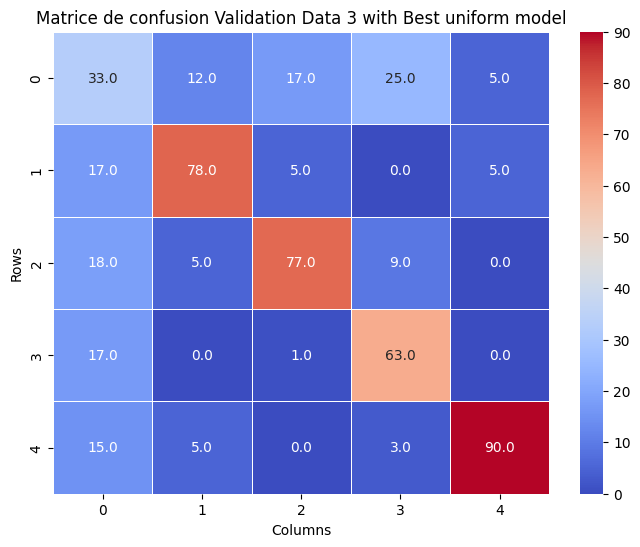

In [45]:
for data in datas:
    X = datas[data][["x1", "x2"]].to_numpy()
    y = datas[data].y.to_numpy().astype(int)
    h_range = np.arange(0.2, 2.2, 0.2)
    parzen_gaussian = [Parzen(kernel=gaussian_kernel, h=i) for i in h_range]
    parzen_uniform = [Parzen(kernel=uniform_kernel, h=i) for i in h_range] 

    gaussian_top1_scores , gaussian_top2_scores= zip(*[cross_validation(kpp, X, y) for kpp in parzen_gaussian])
    uniform_top1_scores, uniform_top2_scores = zip(*[cross_validation(kpp, X, y) for kpp in parzen_uniform])

    h_top_1_gaussian = np.argmax(gaussian_top1_scores) + 1
    h_top_2_gaussian = np.argmax(gaussian_top2_scores) + 1
    h_top_1_uniform = np.argmax(uniform_top1_scores) + 1
    h_top_2_uniform = np.argmax(uniform_top2_scores) + 1

    print(f"dataset {data[-1]}")   
    print(f"best h on gaussian with Top 1 score : {h_top_1_gaussian}, best h on gaussian with Top 2 score : {h_top_2_gaussian}")
    print(f"best h on uniform with Top 1 score : {h_top_1_uniform}, best h on uniform with Top 2 score : {h_top_2_uniform}")


    plt.subplots(1, 2, figsize=(19, 6))
    plt.subplot(1, 2, 1)

    plt.plot(h_range, gaussian_top1_scores, "o-", label="gaussian")
    plt.plot(h_range, uniform_top1_scores, "o-", label="uniform")

    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title(f"Cross-Validation Top 1 for Parzen with gaussian and uniform Kernel on dataset {data[-1]}")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(h_range, gaussian_top2_scores, "o-", label="gaussian")
    plt.plot(h_range, uniform_top2_scores, "o-", label="uniform")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title(f"Cross-Validation Top 2 for Parzen with gaussian and uniform Kernel on dataset {data[-1]}")
    plt.legend()
    plt.show()

    best_gaussian_kpp = parzen_gaussian[h_top_1_gaussian-1]
    best_uniform_kpp = parzen_uniform[h_top_1_uniform-1]
    validate(valid_data[data], best_gaussian_kpp, name=f"Validation Data {data[-1]} with Best gaussian model", top_k_metrics=False)
    validate(valid_data[data], best_uniform_kpp, name=f"Validation Data {data[-1]} with Best uniform model", top_k_metrics=False)
    

## K plus proches voisins

### 1 plus proche voisin

In [ ]:
class KPP(Modele):
    def __init__(self, k, norm=np.linalg.norm):
        self.k = k
        self.norm = norm

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.dist= np.array([[np.linalg.norm(xi - xj) for xj in X] for xi in X])
        self.predictor = self._get_predictor()
        self.rank_predictor = self._get_rank_predictor()

    def _vector_predict(self, x):
        ppv_classes = self.y[np.argsort(self.dist[np.argmin([self.norm(xi - x) for xi in self.X])])][:self.k]
        return np.argmax(np.bincount(ppv_classes.astype(int)))
    
    def _vector_rank_predict(self, x):
        ppv_classes = self.y[np.argsort(self.dist[np.argmin([self.norm(xi - x) for xi in self.X])])][:self.k]
        return np.argsort(np.bincount(ppv_classes.astype(int)))[::-1]
    
    def _get_predictor(self):
        def predict(x):
            if len(x.shape) == 1:
               return self._vector_predict(x)
            return np.array([self._vector_predict(xi) for xi in x])
        return predict

    def _get_rank_predictor(self, k=5):
        max_len = np.unique(self.y).shape[0]
        def predict(x):
            if len(x.shape) == 1:
               pred = self._vector_rank_predict(x)[:max_len]
               pred = np.pad(pred, (0, max_len - len(pred)), 'constant')
               return pred
            pred = [self._vector_rank_predict(xi)[:max_len] for xi in x]
            pred = [np.pad(d, (0, max_len - len(d)), 'constant') for d in pred]
            return np.array(pred)
        return predict



top1 : 0.992
 top2 : 0.992


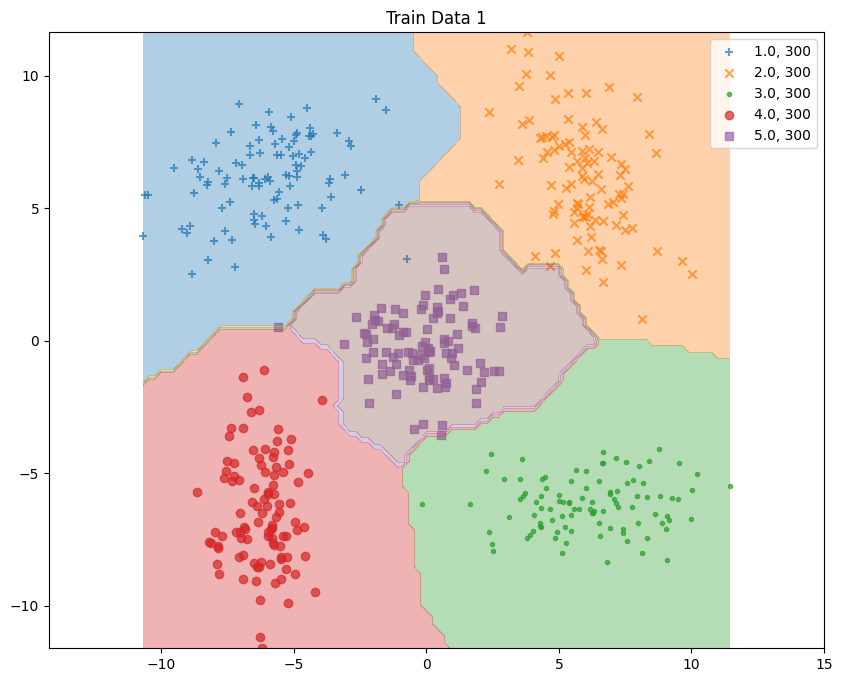

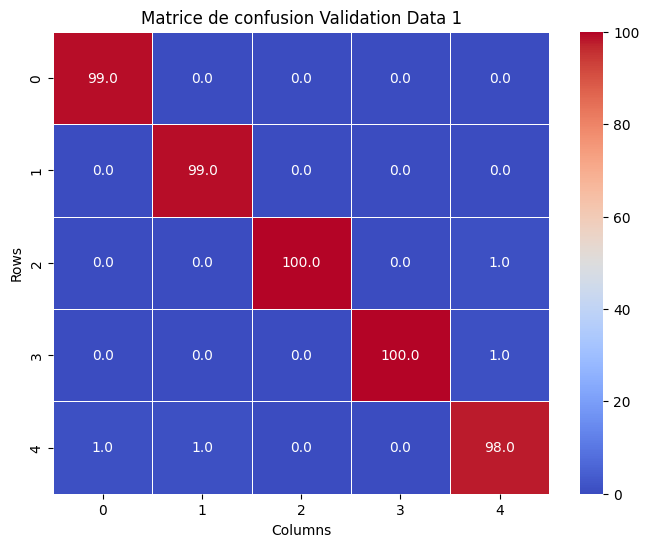

top1 : 0.92
 top2 : 0.948


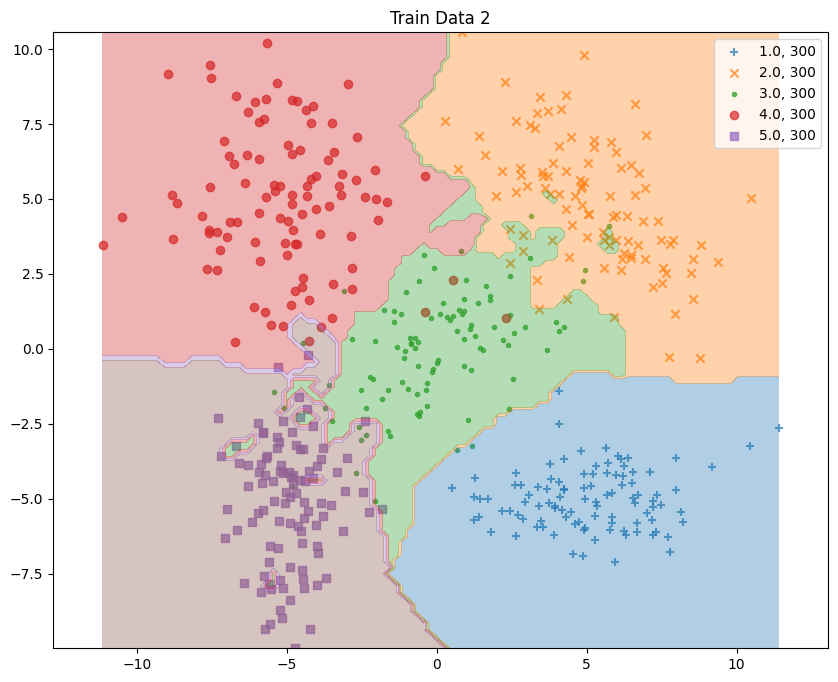

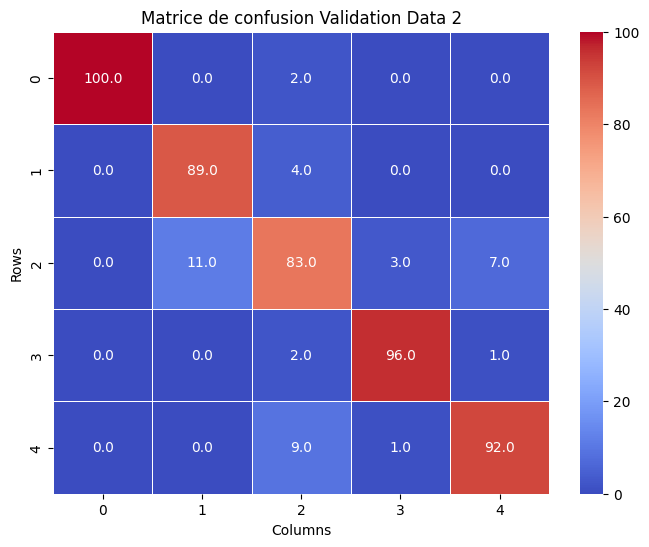

top1 : 0.646
 top2 : 0.7


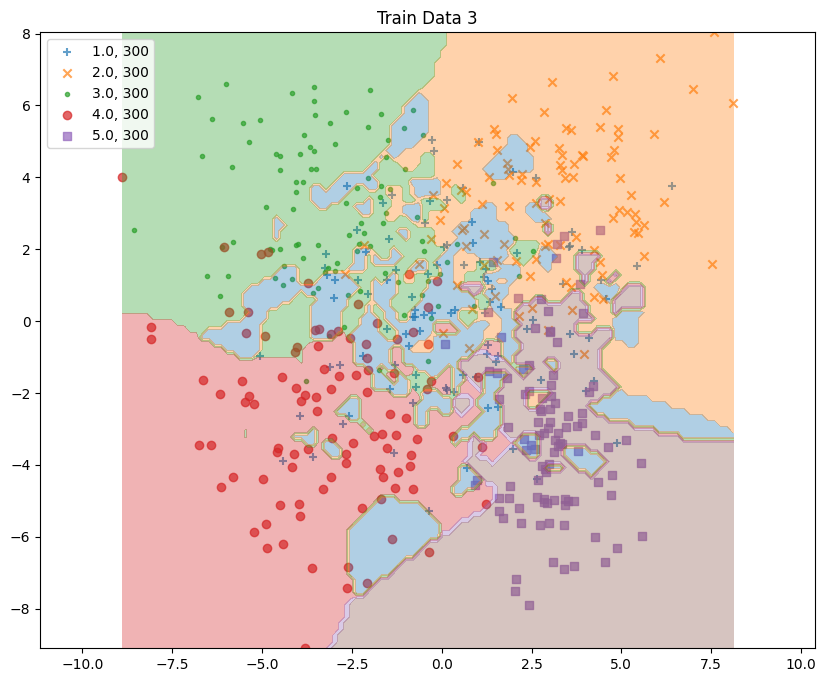

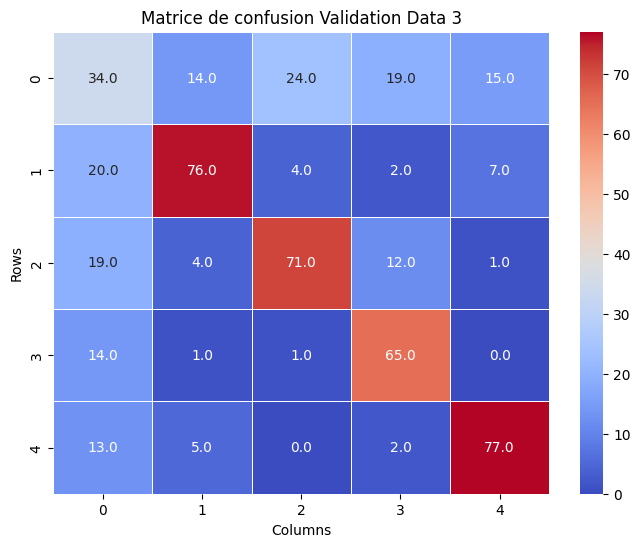

[[np.float64(0.992), np.float64(0.992)],
 [np.float64(0.92), np.float64(0.948)],
 [np.float64(0.646), np.float64(0.7)]]

In [8]:
kpp = KPP(1)
execute_modele(kpp, sample=100, top_k_metrics=True)

In [7]:
class KPP(Modele):
    def __init__(self, k, norm=np.linalg.norm, criteria="majority"):
        self.k = k
        self.norm = norm
        if criteria in ["majority", "unanimity"]:
            self.criteria = criteria

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.dist= np.array([[np.linalg.norm(xi - xj) for xj in X] for xi in X])
        self.predictor = self._get_predictor()
        self.rank_predictor = self._get_rank_predictor()

    def _vector_predict(self, x):
        ppv_classes = self.y[np.argsort(self.dist[np.argmin([self.norm(xi - x) for xi in self.X])])][:self.k]
        if self.criteria == "majority":
            return np.argmax(np.bincount(ppv_classes.astype(int)))
        else:
            if np.all(ppv_classes == ppv_classes[0]):
                return ppv_classes[0]
            else:
                return -1
    
    def _vector_rank_predict(self, x):
        ppv_classes = self.y[np.argsort(self.dist[np.argmin([self.norm(xi - x) for xi in self.X])])][:self.k]
        return np.argsort(np.bincount(ppv_classes.astype(int)))[::-1]
    
    def _get_predictor(self):
        def predict(x):
            if len(x.shape) == 1:
               return self._vector_predict(x)
            return np.array([self._vector_predict(xi) for xi in x])
        return predict

    def _get_rank_predictor(self, k=5):
        max_len = np.unique(self.y).shape[0]
        def predict(x):
            if len(x.shape) == 1:
               pred = self._vector_rank_predict(x)[:max_len]
               pred = np.pad(pred, (0, max_len - len(pred)), 'constant')
               return pred
            pred = [self._vector_rank_predict(xi)[:max_len] for xi in x]
            pred = [np.pad(d, (0, max_len - len(d)), 'constant') for d in pred]
            return np.array(pred)
        return predict



In [39]:
l = [(2, 3), (3, 5)]
list(zip(*l))

[(2, 3), (3, 5)]

dataset 1
best K on Unanimity with Top 1 score : 1, best K on Unanimity with Top 2 score : 1
best K on Majority with Top 1 score : 2, best K on Majority with Top 2 score : 2


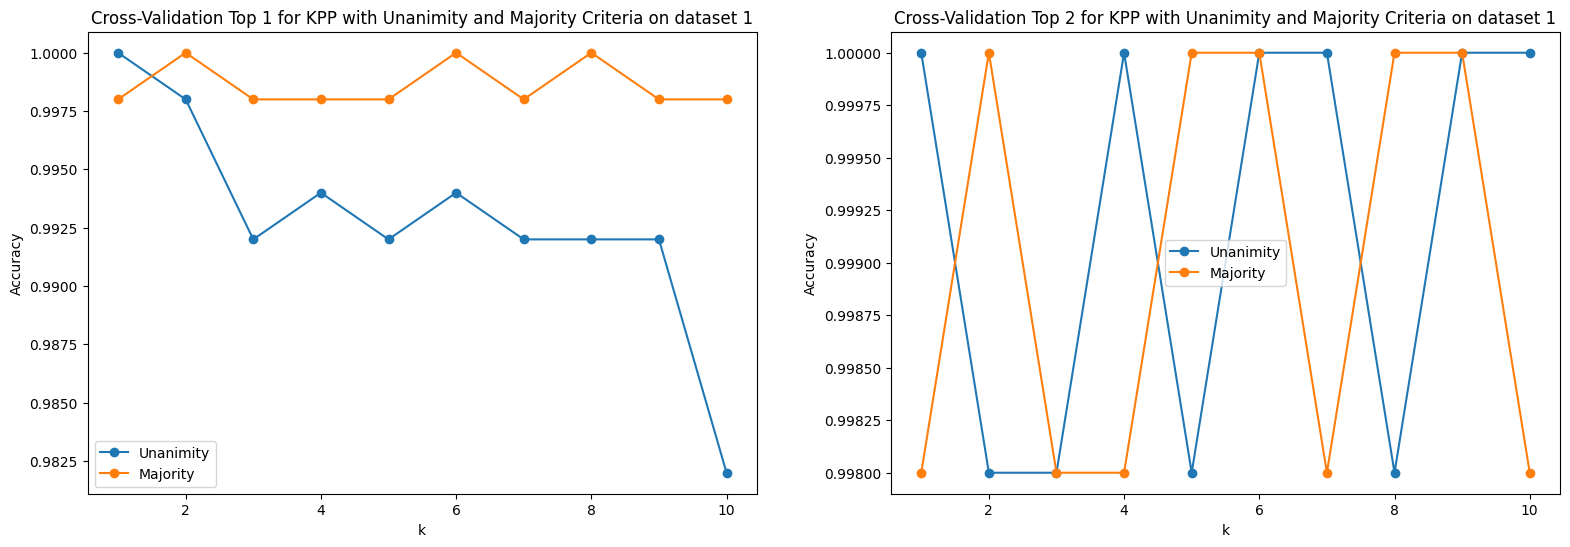

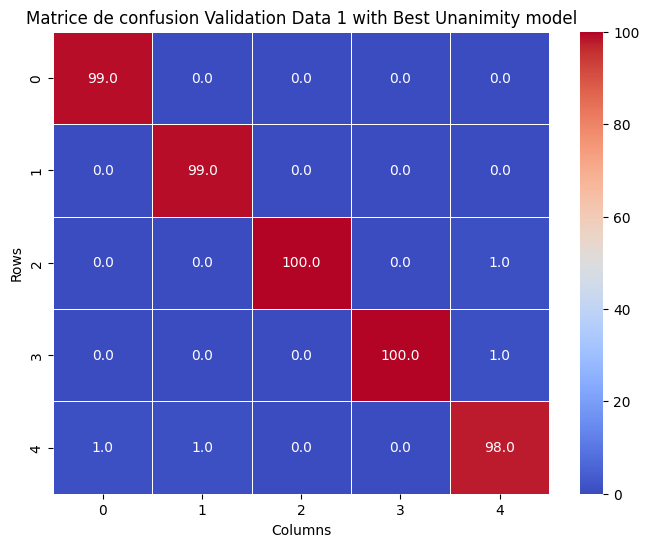

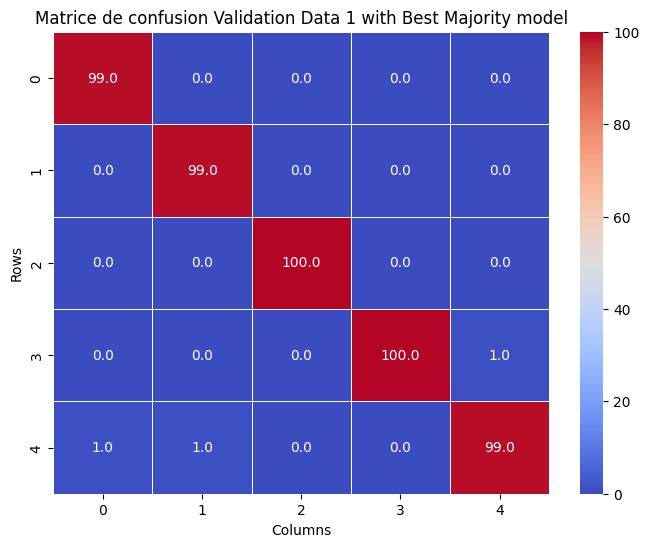

dataset 2
best K on Unanimity with Top 1 score : 1, best K on Unanimity with Top 2 score : 7
best K on Majority with Top 1 score : 8, best K on Majority with Top 2 score : 7


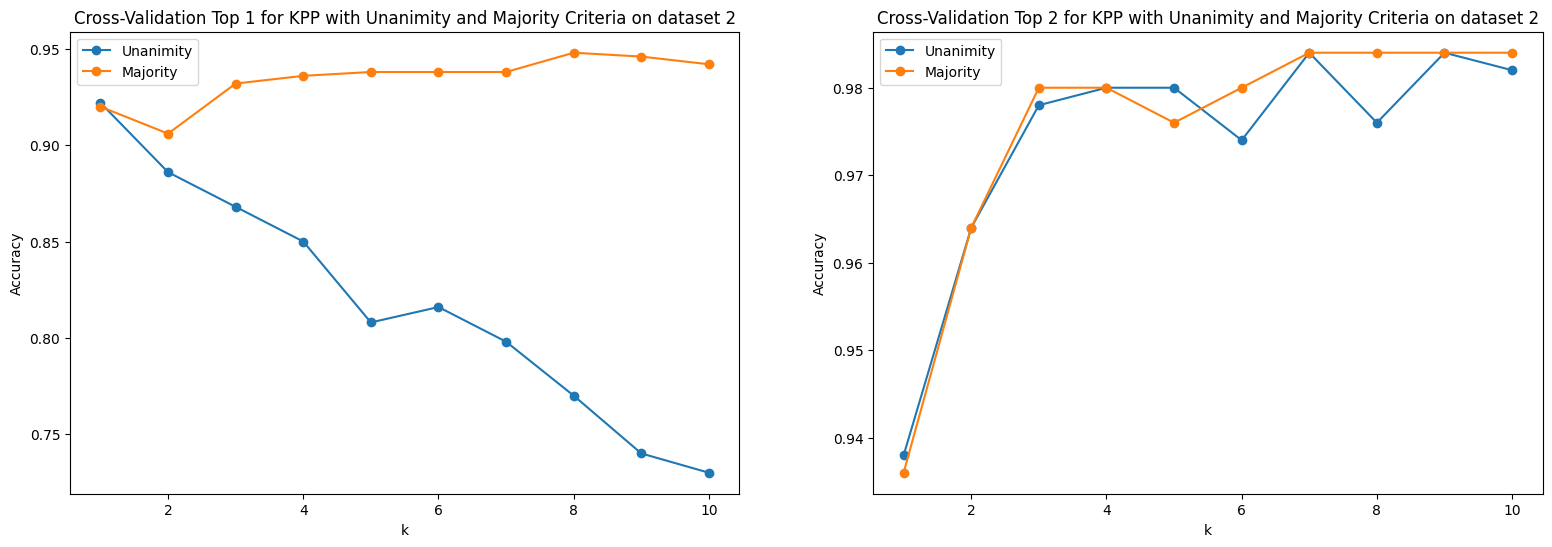

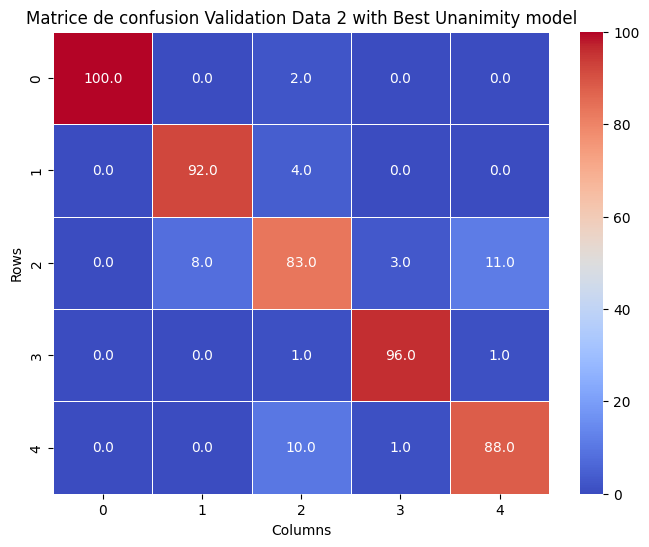

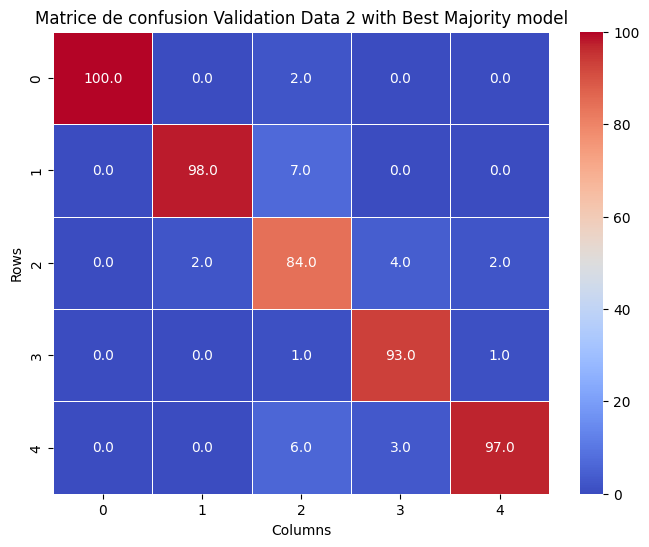

dataset 3
best K on Unanimity with Top 1 score : 1, best K on Unanimity with Top 2 score : 9
best K on Majority with Top 1 score : 9, best K on Majority with Top 2 score : 10


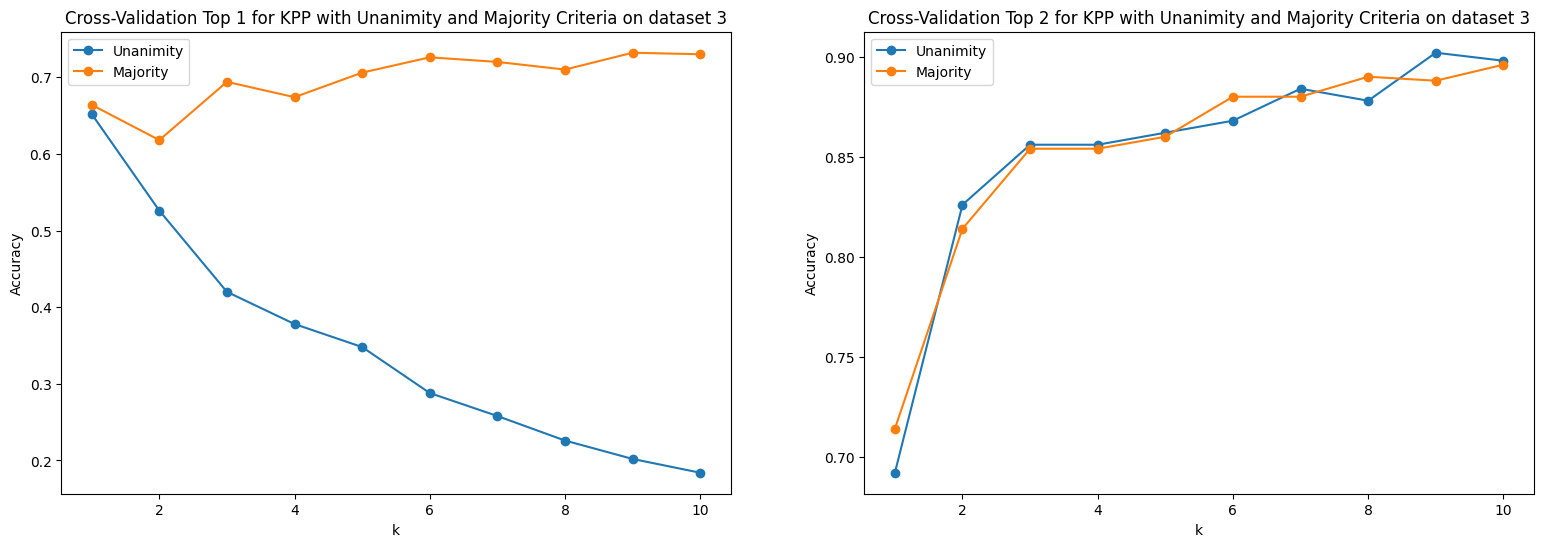

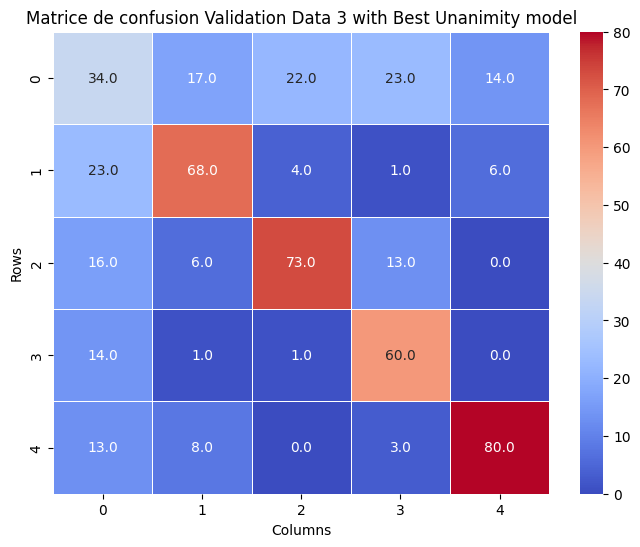

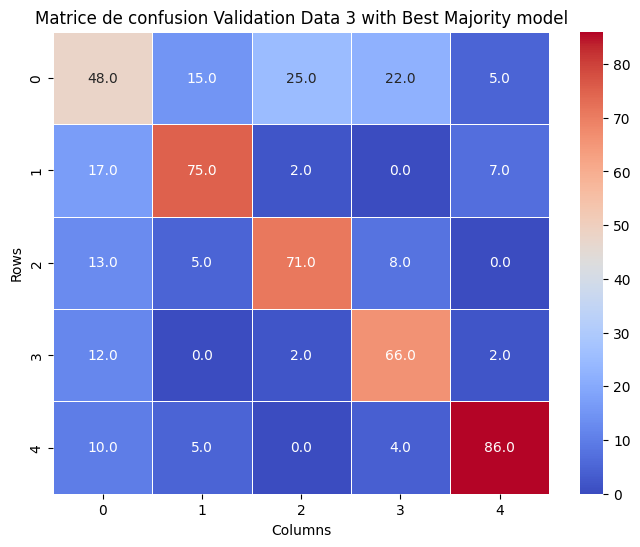

In [45]:
for data in datas:
    X = datas[data][["x1", "x2"]].to_numpy()
    y = datas[data].y.to_numpy().astype(int)

    unanimity_kpp = [KPP(k, criteria="unanimity") for k in range(1, 11)]
    majority_kpp = [KPP(k, criteria="majority") for k in range(1, 11)]

    unanimity_top1_scores , unanimity_top2_scores= zip(*[cross_validation(kpp, X, y) for kpp in unanimity_kpp])
    majority_top1_scores, majority_top2_scores = zip(*[cross_validation(kpp, X, y) for kpp in majority_kpp])

    k_top_1_unanimity = np.argmax(unanimity_top1_scores) + 1
    k_top_2_unanimity = np.argmax(unanimity_top2_scores) + 1
    k_top_1_majority = np.argmax(majority_top1_scores) + 1
    k_top_2_majority = np.argmax(majority_top2_scores) + 1

    print(f"dataset {data[-1]}")   
    print(f"best K on Unanimity with Top 1 score : {k_top_1_unanimity}, best K on Unanimity with Top 2 score : {k_top_2_unanimity}")
    print(f"best K on Majority with Top 1 score : {k_top_1_majority}, best K on Majority with Top 2 score : {k_top_2_majority}")


    plt.subplots(1, 2, figsize=(19, 6))
    plt.subplot(1, 2, 1)

    plt.plot(range(1, 11), unanimity_top1_scores, "o-", label="Unanimity")
    plt.plot(range(1, 11), majority_top1_scores, "o-", label="Majority")

    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title(f"Cross-Validation Top 1 for KPP with Unanimity and Majority Criteria on dataset {data[-1]}")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(range(1, 11), unanimity_top2_scores, "o-", label="Unanimity")
    plt.plot(range(1, 11), majority_top2_scores, "o-", label="Majority")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title(f"Cross-Validation Top 2 for KPP with Unanimity and Majority Criteria on dataset {data[-1]}")
    plt.legend()
    plt.show()

    best_unanimity_kpp = unanimity_kpp[k_top_1_unanimity-1]
    best_majority_kpp = majority_kpp[k_top_1_majority-1]
    validate(valid_data[data], best_unanimity_kpp, name=f"Validation Data {data[-1]} with Best Unanimity model", top_k_metrics=False)
    validate(valid_data[data], best_majority_kpp, name=f"Validation Data {data[-1]} with Best Majority model", top_k_metrics=False)
    

In [43]:
unanimity_top1_scores

(np.float64(0.9960000000000001),
 np.float64(0.9960000000000001),
 np.float64(0.994),
 np.float64(0.9960000000000001),
 np.float64(0.9940000000000001),
 np.float64(0.994),
 np.float64(0.992),
 np.float64(0.9880000000000001),
 np.float64(0.9879999999999999),
 np.float64(0.986))

## Séperation Lineaire

In [ ]:
class Perceptron(Modele):
    def __init__(self, max_iter=100, **kwargs):
        super().__init__()
        self.max_iter = max_iter

    def fit(self, X, y):
        self.classes = np.unique(y)
        X_0 = X[y == self.classes[0]]
        X_1 = X[y == self.classes[1]]

        self.X_t = np.concatenate([X_0, np.ones((X_0.shape[0], 1))], axis=1)
        self.X_t = np.concatenate([self.X_t, np.concatenate([-X_1, -np.ones((X_1.shape[0], 1))], axis=1)], axis=0)
        self.w = np.zeros(self.X_t.shape[1])
        #y_t = np.concatenate([np.ones(X_0.shape[0]), -np.ones(X_1.shape[0])])
        iter = 0
        well_classified = 0
        self.error_count=[]
        while well_classified != self.X_t.shape[0] and iter < self.max_iter:
            errors=0
            for i in range(self.X_t.shape[0]):
                x = self.X_t[i]
                if x@self.w <= 0:
                    self.w += x
                    well_classified = 0
                    errors += 1 
                else:
                    well_classified += 1

                if well_classified == self.X_t.shape[0]:
                    break
            self.error_count.append(errors)
            iter += 1
        
        self.predictor = self._get_predictor()

    def _get_predictor(self):
        def predict(x):
            if len(x.shape) == 1:
                x = np.concatenate([x, [1]])
                return self.classes[0] if x@self.w > 0 else self.classes[1]
            x = np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)
            res =  (x@self.w < 0).astype(int)
            return np.where(res == 0, self.classes[0], self.classes[1])
        return predict



[1 1 1 1]


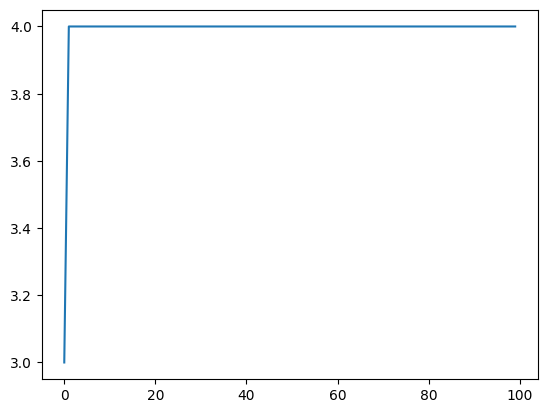

In [9]:

perceptron = Perceptron()

X = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1]
])

y = np.array([0, 1, 1, 0])


perceptron.fit(X, y)

print(perceptron.predictor(X))

errors = perceptron.error_count
plt.plot(errors)
plt.show()

In [50]:
class LineairSeparator(Modele):
    def __init__(self, perceptronModel=Perceptron, perceptron_kwargs={}):
        self.perceptronModel = perceptronModel
        self.perceptron_kwargs = perceptron_kwargs

        
    def fit(self, X, y):
        self.classes = np.unique(y).tolist()
        classes_combinations = list(combinations(self.classes, 2))
        self.perceptrons = []
        for comb in classes_combinations:
            perceptron = self.perceptronModel(**self.perceptron_kwargs)
            X_train = np.concatenate((
                X[y == comb[0]],
                X[y == comb[1]]
            ), axis=0) 
            y_train = np.concatenate((
                y[y == comb[0]],
                y[y == comb[1]]
            ), axis=0) 
            perceptron.fit(X_train, y_train)
            self.perceptrons.append(perceptron)
        
        self.predictor = self._get_predictor()


    def _get_predictor(self):
        def predict(x):
            if len(x.shape) == 1:
                preds = [perceptron.predictor(x) for perceptron in self.perceptrons]
                return np.array([np.argmax(np.bincount(preds))])
            preds = [
                [perceptron.predictor(xi) for perceptron in self.perceptrons] for xi in x]
            preds = np.array(preds).astype(int)
            return np.array([np.argmax(classes) for classes in [np.bincount(pred) for pred in preds]])
        return predict



In [49]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of examples per class
n_samples = 100 // 3

# Generate random data for three classes
class1 = np.random.randn(n_samples, 2) + np.array([0, 0])
class2 = np.random.randn(n_samples, 2) + np.array([5, 5])
class3 = np.random.randn(n_samples, 2) + np.array([-5, 5])

# Combine the data
X = np.vstack((class1, class2, class3))
y = np.array([1]*n_samples + [2]*n_samples + [3]*n_samples)

lineair_separator = LineairSeparator(perceptron_kwargs={"max_iter": 100})
lineair_separator.fit(X, y)

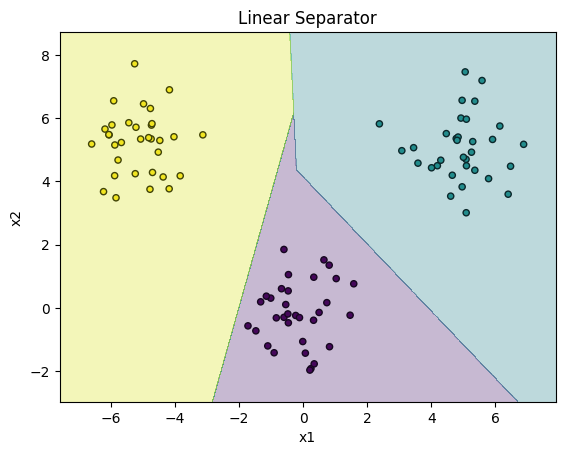

In [42]:
def plot_linear_separator(model, X, y):
    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=20)
    
    # Create a mesh grid for plotting decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict the class for each point in the mesh grid
   
    Z = model.predictor(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title('Linear Separator')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

# Example usage

plot_linear_separator(lineair_separator, X, y)

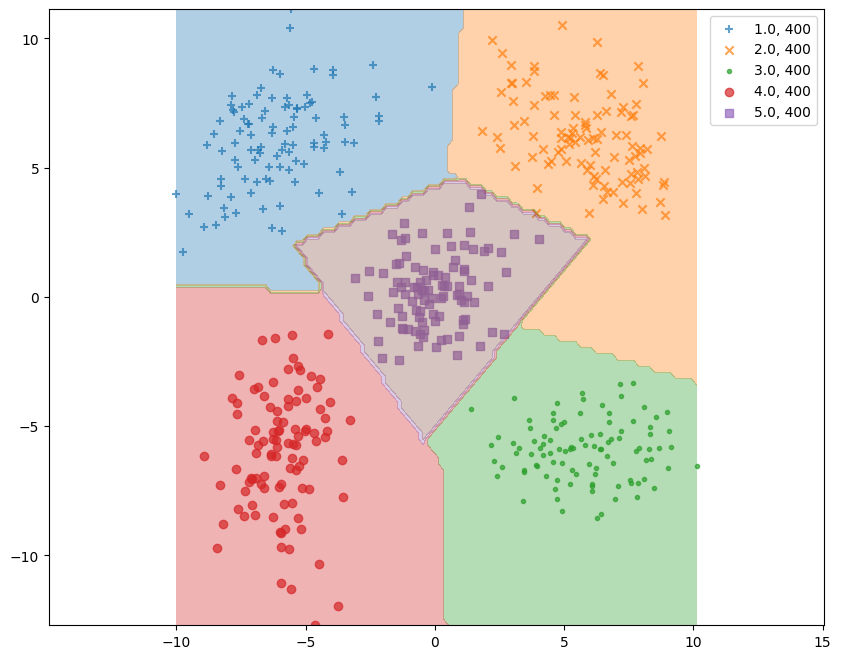

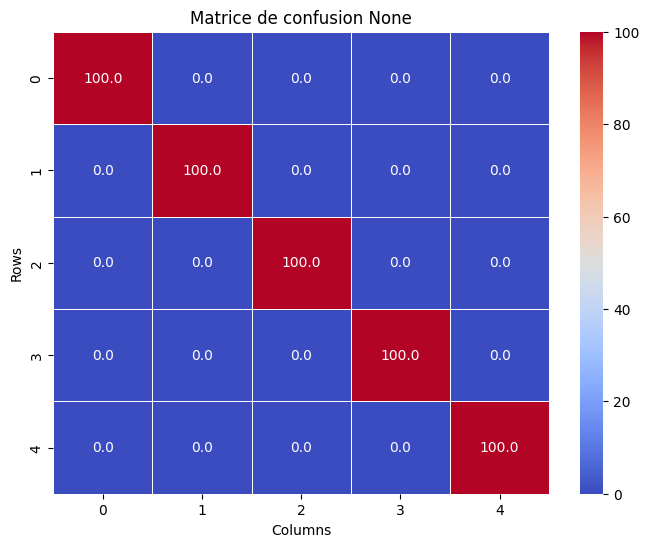

In [76]:
lineair_separator.fit(X1, y1)

execute_modele(lineair_separator, data=datas["data1"], sample=100)

## Seperateur lineaire adapté

In [52]:
class PerceptronV2(Modele):
    def __init__(self, max_iter=100, batch_size=1, epoch=5):
        super().__init__()
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.epoch = epoch
        self.epoch_on_trainning = 0

    def create_batch(self, X):
        for i in range(0, X.shape[0], self.batch_size):
            yield X[i:i+self.batch_size]

    def fit(self, X, y):
        self.classes = np.unique(y)
        X_0 = X[y == self.classes[0]]
        X_1 = X[y == self.classes[1]]

        self.X_t = np.concatenate([X_0, np.ones((X_0.shape[0], 1))], axis=1)
        self.X_t = np.concatenate([self.X_t, np.concatenate([-X_1, -np.ones((X_1.shape[0], 1))], axis=1)], axis=0)
        self.w = np.zeros(self.X_t.shape[1])

        iter = 0
        well_classified = 0
        while iter < self.epoch:
            well_classified = 0
            for batch_X in self.create_batch(self.X_t):
                batch_hyt = batch_X@self.w
                correction = batch_X[batch_hyt <= 0]
                if correction.size != 0:
                    self.w += np.sum(correction, axis=0)
                else:
                    well_classified += len(batch_X) - len(correction)
            
            if well_classified == self.X_t.shape[0]:
                break
            iter += 1
            
        print(f"epoch {iter} : {well_classified} well classified")
        self.predictor = self._get_predictor()

    def _get_predictor(self):
        def predict(x):
            if len(x.shape) == 1:
                x = np.concatenate([x, [1]])
                return self.classes[0] if x@self.w > 0 else self.classes[1]
            x = np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)
            res =  (x@self.w < 0).astype(int)
            return np.where(res == 0, self.classes[0], self.classes[1])
        return predict



epoch 2 : 200 well classified
epoch 6 : 200 well classified
epoch 1 : 200 well classified
epoch 1 : 200 well classified
epoch 50 : 140 well classified
epoch 50 : 140 well classified
epoch 1 : 200 well classified
epoch 50 : 160 well classified
epoch 50 : 60 well classified
epoch 50 : 160 well classified


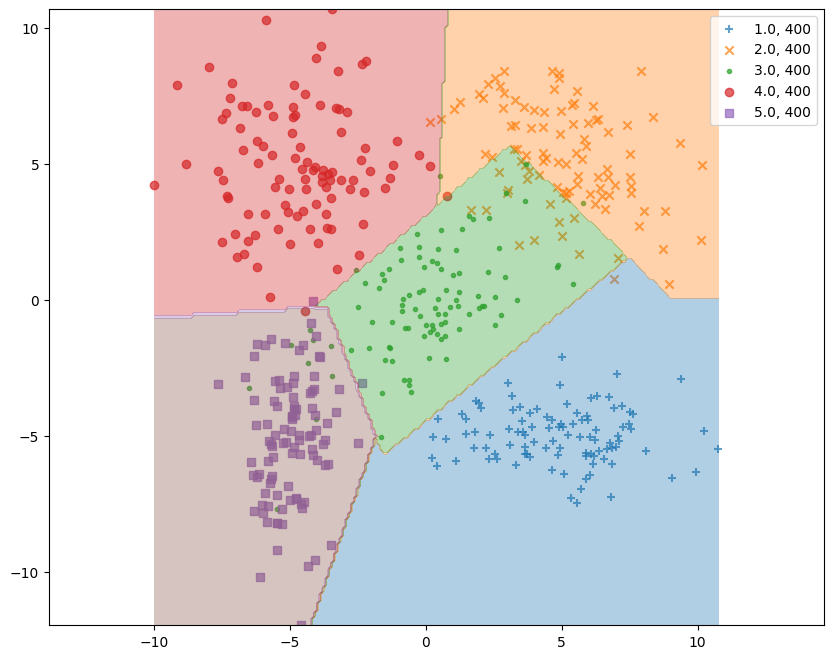

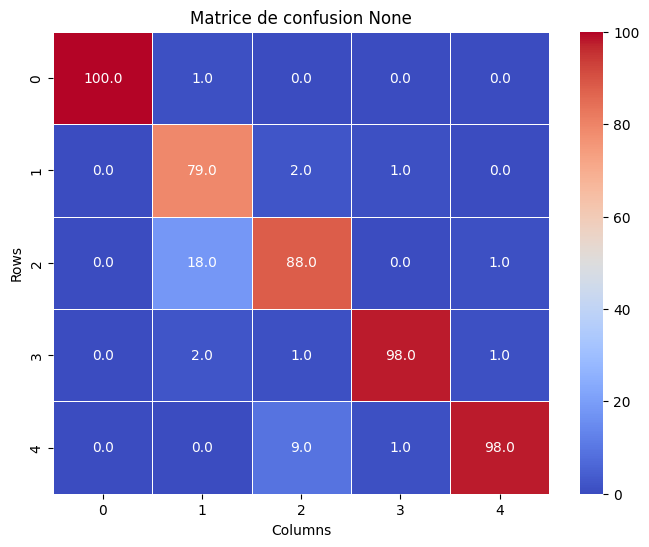

In [54]:
lineair_separator = LineairSeparator(perceptronModel=PerceptronV2, perceptron_kwargs={"batch_size": 20, "epoch": 50})
execute_modele(lineair_separator, data=datas["data2"], sample=200)

epoch 50 : 60 well classified
epoch 50 : 40 well classified
epoch 50 : 60 well classified
epoch 50 : 60 well classified
epoch 50 : 80 well classified
epoch 50 : 120 well classified
epoch 50 : 120 well classified
epoch 50 : 120 well classified
epoch 50 : 140 well classified
epoch 50 : 120 well classified


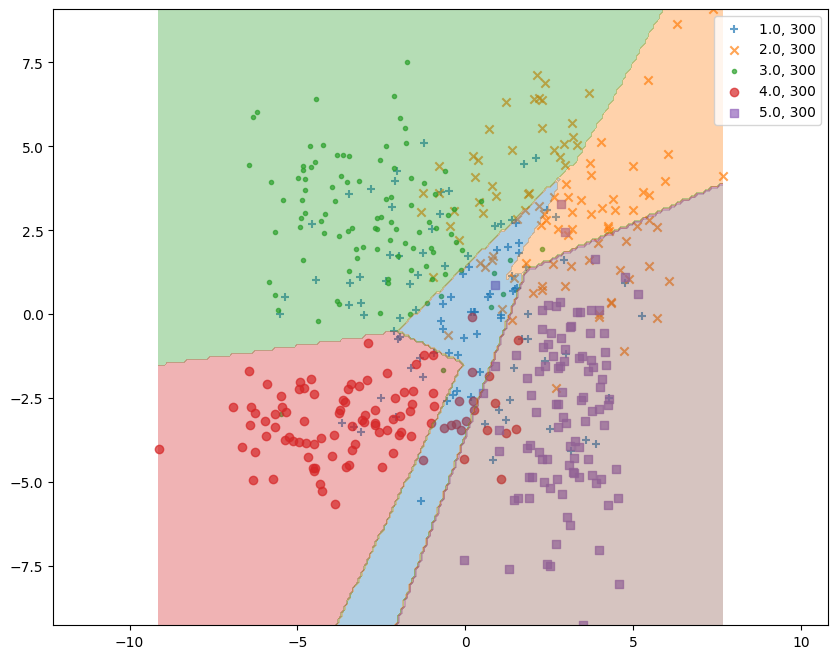

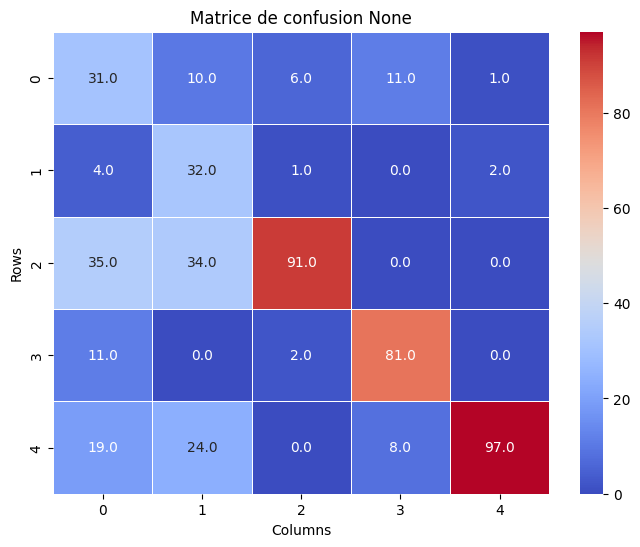

In [55]:
execute_modele(lineair_separator, data=datas["data3"], sample=200)

In [60]:

# Filter out class 5 from all datasets
datas = {key: value[value.y != 5] for key, value in datas.items()}
valid_data = {key: value[value.y != 5] for key, value in valid_data.items()}

epoch 1 : 200 well classified
epoch 1 : 200 well classified
epoch 1 : 200 well classified
epoch 1 : 200 well classified
epoch 1 : 200 well classified
epoch 2 : 200 well classified


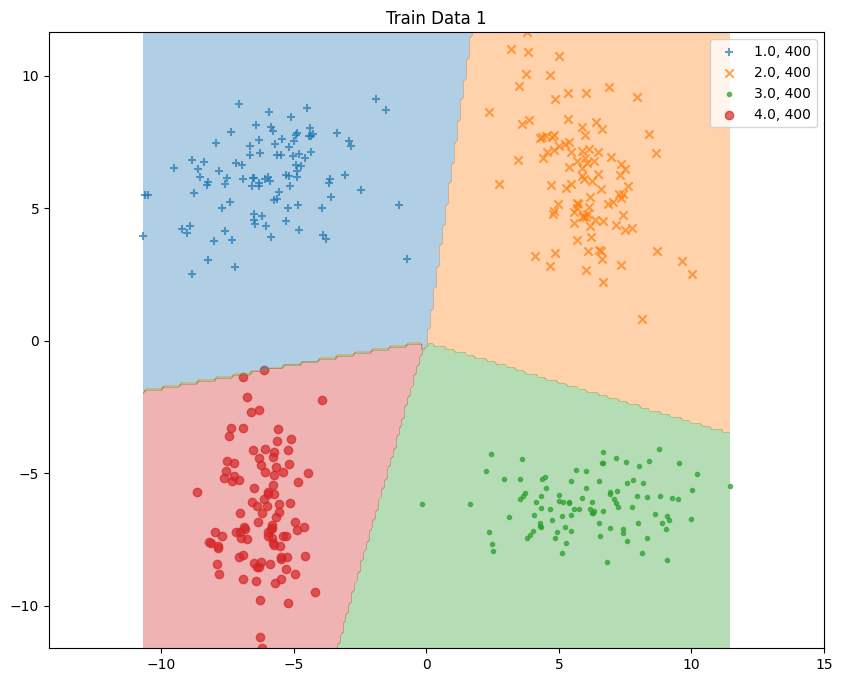

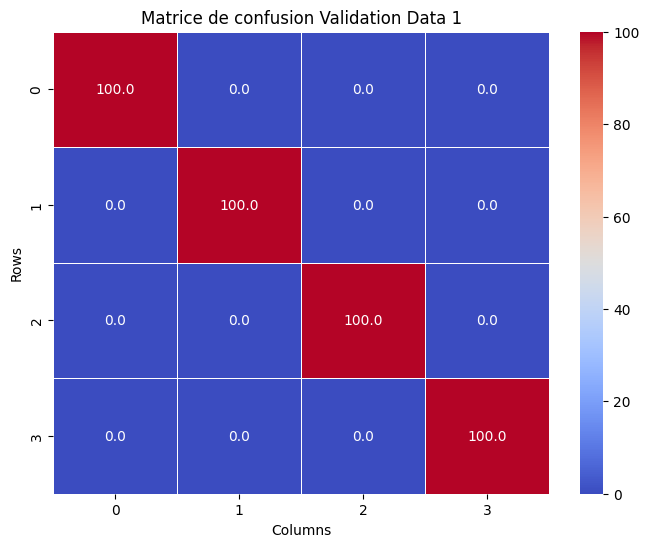

epoch 2 : 200 well classified
epoch 6 : 200 well classified
epoch 1 : 200 well classified
epoch 50 : 140 well classified
epoch 50 : 140 well classified
epoch 50 : 160 well classified


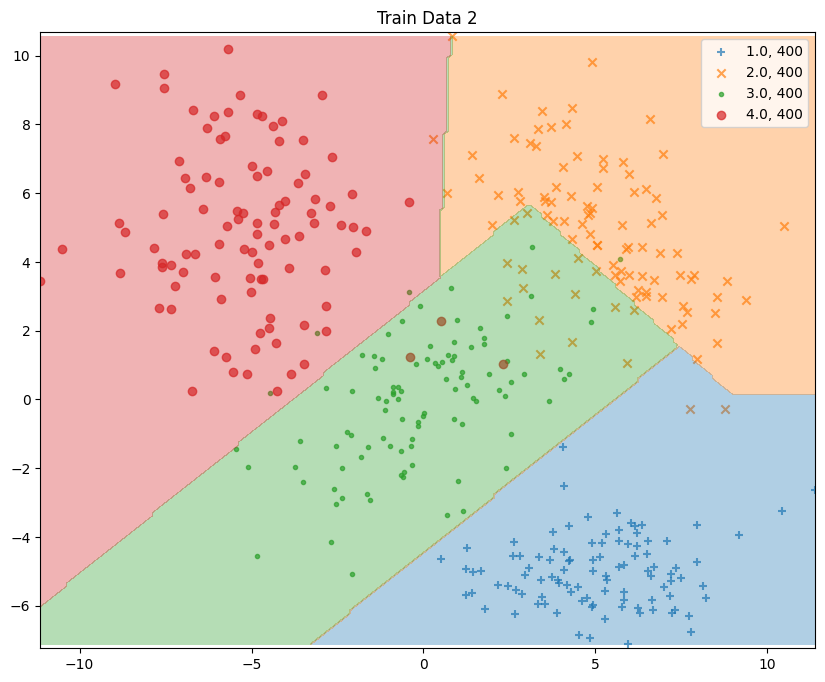

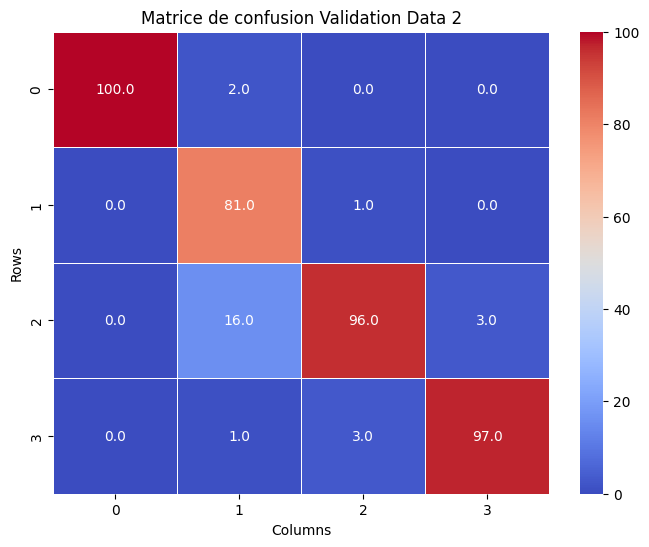

epoch 50 : 60 well classified
epoch 50 : 40 well classified
epoch 50 : 60 well classified
epoch 50 : 80 well classified
epoch 50 : 120 well classified
epoch 50 : 120 well classified


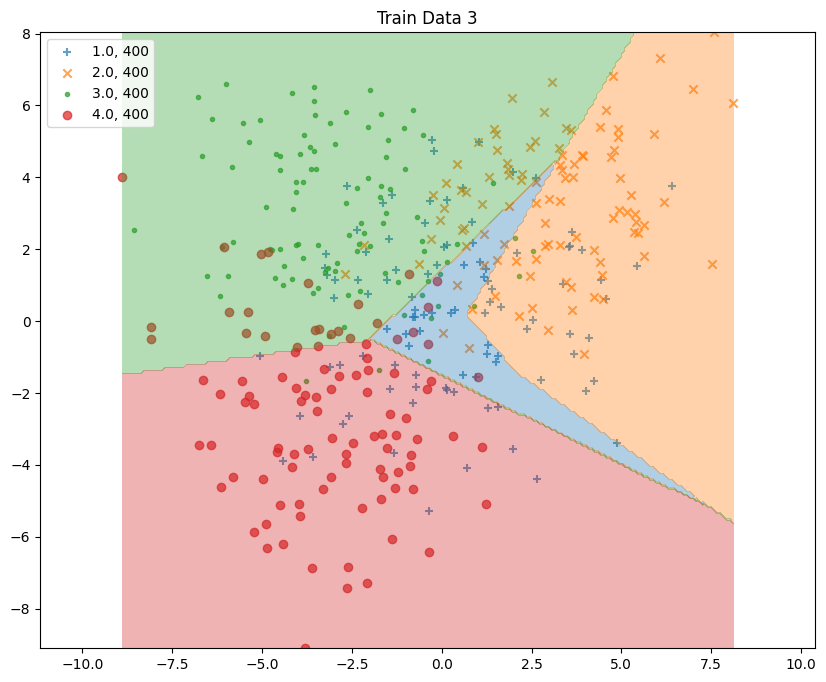

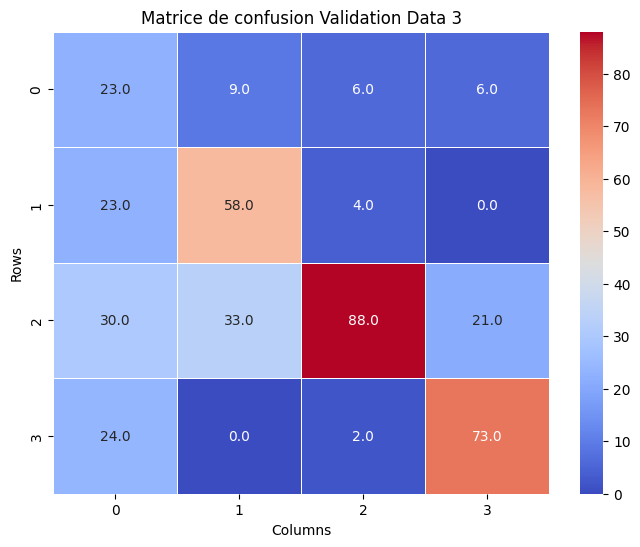

In [61]:
lineair_separator = LineairSeparator(perceptronModel=PerceptronV2, perceptron_kwargs={"batch_size": 20, "epoch": 50})
execute_modele(lineair_separator, sample=200)